<a href="https://colab.research.google.com/github/Imtiaj-Sajin/pdf-to-excel/blob/main/RentRoll_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pdfplumber pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 721.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving VV_Oct Rent Roll.pdf to VV_Oct Rent Roll.pdf


# Commercial Single Family

In [ ]:
import pdfplumber

pdf = pdfplumber.open("/content/rentrollComSingle.pdf")
len(pdf.pages)


5

In [ ]:
page = pdf.pages[0]
page.width, page.height

(792, 612)

In [ ]:
words = page.extract_words(
    use_text_flow=False,
    keep_blank_chars=True
)

words[:100]


[{'text': 'Database:',
  'x0': 30.6,
  'x1': 62.492,
  'top': 40.47090000000003,
  'doctop': 40.47090000000003,
  'bottom': 47.47090000000003,
  'upright': True,
  'height': 7.0,
  'width': 31.891999999999996,
  'direction': 'ltr'},
 {'text': 'RCGVENTURES',
  'x0': 75.6,
  'x1': 129.227,
  'top': 40.47090000000003,
  'doctop': 40.47090000000003,
  'bottom': 47.47090000000003,
  'upright': True,
  'height': 7.0,
  'width': 53.62700000000001,
  'direction': 'ltr'},
 {'text': 'RentRoll',
  'x0': 378.6488,
  'x1': 411.5459,
  'top': 39.68820000000005,
  'doctop': 39.68820000000005,
  'bottom': 47.68820000000005,
  'upright': True,
  'height': 8.0,
  'width': 32.89710000000002,
  'direction': 'ltr'},
 {'text': 'Page:',
  'x0': 697.807,
  'x1': 716.084,
  'top': 40.47090000000003,
  'doctop': 40.47090000000003,
  'bottom': 47.47090000000003,
  'upright': True,
  'height': 7.0,
  'width': 18.27699999999993,
  'direction': 'ltr'},
 {'text': '1',
  'x0': 758.7069,
  'x1': 762.5989000000001,
  '

## Debug1

In [ ]:
import pdfplumber
import pandas as pd

def debug_pdf_layout(pdf_path, page_index=2):
    print(f"--- ANALYZING PAGE {page_index + 1} ---")
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[page_index]
        words = page.extract_words(keep_blank_chars=False)

        # 1. Detect Header Row using 'Occupant' as anchor
        # We look for the word containing "Occupant" to find the Y-axis (top)
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)

        if not header_anchor:
            print("ERROR: Could not find 'Occupant' header on this page.")
            return

        header_top = header_anchor['top']
        print(f"Header Detected at Y-Position: {header_top}")

        # 2. Get all words in that Header Row (with slight tolerance)
        header_row_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_row_words.sort(key=lambda x: x['x0'])

        print(f"\nDetected {len(header_row_words)} Columns:")
        print(f"{'Text':<20} | {'X-Start':<10} | {'X-End':<10}")
        print("-" * 50)

        column_boundaries = []
        for w in header_row_words:
            print(f"{w['text']:<20} | {w['x0']:<10.2f} | {w['x1']:<10.2f}")
            column_boundaries.append(w['x0'])

        return header_top

# Run Debug
pdf_path = "/content/rentrollComSingle.pdf"
debug_pdf_layout(pdf_path, page_index=2) # Checking Page 3 as per your snippet

--- ANALYZING PAGE 3 ---
Header Detected at Y-Position: 99.57090000000005

Detected 15 Columns:
Text                 | X-Start    | X-End     
--------------------------------------------------
BldgId               | 26.10      | 47.89     
SuitId               | 53.10      | 72.94     
OccupantName         | 84.60      | 135.18    
RentStart            | 206.10     | 237.59    
Expiration           | 251.10     | 282.21    
Sqft                 | 328.65     | 341.08    
BaseRent             | 362.41     | 395.09    
RatePSF              | 405.26     | 435.58    
CostRecovery         | 448.20     | 494.10    
Stop                 | 520.20     | 534.59    
OtherIncome          | 550.69     | 593.09    
Cat                  | 606.60     | 617.49    
Date                 | 633.60     | 648.38    
MonthlyAmount        | 673.02     | 723.58    
PSF                  | 741.49     | 755.08    


99.57090000000005

In [ ]:
import pdfplumber
from PIL import Image
import os

# CONFIGURATION
pdf_path = "/content/rentrollComSingle.pdf"
output_folder = "table_debug_images"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def debug_table_detection(pdf_path):
    print(f"Processing {pdf_path}...")

    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            page_num = i + 1
            print(f"Scanning Page {page_num}...")

            # Convert page to image for visualization
            im = page.to_image(resolution=150)

            # 1. FIND TABLES
            # We use default settings first. This looks for solid lines.
            tables = page.find_tables(table_settings={
                "vertical_strategy": "lines",
                "horizontal_strategy": "lines",
                "snap_tolerance": 3,
            })

            if tables:
                print(f"  -> Found {len(tables)} tables on Page {page_num}")

                # Draw Red Box around the whole table
                for table in tables:
                    bbox = table.bbox
                    im.draw_rect(bbox, stroke="red", stroke_width=3)

                    # Draw Blue Lines for rows/cols inside
                    # This helps us see if it's splitting cells correctly
                    for row in table.rows:
                        for cell in row.cells:
                            if cell: # cell is a tuple (x0, top, x1, bottom)
                                im.draw_rect(cell, stroke="blue", stroke_width=1)
            else:
                print(f"  -> No tables detected on Page {page_num} (using line detection).")

            # Save the debug image
            image_path = f"{output_folder}/page_{page_num}_debug.png"
            im.save(image_path)

    print(f"\nDone. Please check the folder '{output_folder}' and look at the images.")

debug_table_detection(pdf_path)

Processing /content/rentrollComSingle.pdf...
Scanning Page 1...
  -> Found 4 tables on Page 1
Scanning Page 2...
  -> Found 11 tables on Page 2
Scanning Page 3...
  -> Found 12 tables on Page 3
Scanning Page 4...
  -> Found 6 tables on Page 4
Scanning Page 5...
  -> Found 2 tables on Page 5

Done. Please check the folder 'table_debug_images' and look at the images.


In [ ]:
import pdfplumber
from PIL import Image
import os

# CONFIGURATION
pdf_path = "/content/rentrollComSingle.pdf"
output_folder = "table_debug_images_v3"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def comprehensive_debug(pdf_path):
    print(f"Processing {pdf_path}...")

    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            page_num = i + 1
            print(f"\n{'='*60}")
            print(f"PAGE {page_num}")
            print(f"{'='*60}")

            # Basic page info
            print(f"Dimensions: {page.width} x {page.height}")

            # ===== DEBUG 1: LINE DETECTION =====
            print(f"\n--- LINE DETECTION ---")
            h_edges = page.horizontal_edges
            v_edges = page.vertical_edges
            print(f"Horizontal edges detected: {len(h_edges)}")
            print(f"Vertical edges detected: {len(v_edges)}")

            # Create image for line visualization
            im_lines = page.to_image(resolution=150)

            # Draw all edges with labels
            for idx, line in enumerate(h_edges[:20]):  # Show first 20
                im_lines.draw_line(
                    [(line['x0'], line['y0']), (line['x1'], line['y1'])],
                    stroke="red", stroke_width=2
                )
                if idx < 5:  # Print first 5
                    print(f"  H-edge {idx}: Y={line['y0']:.1f}, X=[{line['x0']:.1f} to {line['x1']:.1f}], width={line['x1']-line['x0']:.1f}")

            for idx, line in enumerate(v_edges[:20]):  # Show first 20
                im_lines.draw_line(
                    [(line['x0'], line['y0']), (line['x1'], line['y1'])],
                    stroke="blue", stroke_width=2
                )
                if idx < 5:  # Print first 5
                    print(f"  V-edge {idx}: X={line['x0']:.1f}, Y=[{line['top']:.1f} to {line['bottom']:.1f}], height={line['bottom']-line['top']:.1f}")

            im_lines.save(f"{output_folder}/page_{page_num}_01_all_lines.png")
            print(f"  Saved: page_{page_num}_01_all_lines.png (Red=H, Blue=V)")

            # ===== DEBUG 2: DETECT TOP BORDERED BOX =====
            print(f"\n--- TOP BOX DETECTION ---")

            # The top box should be:
            # 1. Near the top of the page
            # 2. Have full-width horizontal lines
            # 3. Have a horizontal divider inside

            # Sort horizontal edges by Y position
            h_sorted = sorted(h_edges, key=lambda x: x['y0'])

            # Find the top box boundaries
            # Look for horizontal lines that span most of the page width
            page_width = page.width
            full_width_threshold = page_width * 0.8  # At least 80% of page width

            top_h_lines = []
            for line in h_sorted[:15]:  # Check first 15 horizontal lines
                line_width = line['x1'] - line['x0']
                if line_width >= full_width_threshold:
                    top_h_lines.append(line)
                    print(f"  Full-width H-line at Y={line['y0']:.1f}, width={line_width:.1f}")

            if len(top_h_lines) >= 2:
                # First full-width line should be top of box
                box_top_line = top_h_lines[0]
                print(f"\n  Box top border: Y={box_top_line['y0']:.1f}")

                # Find the divider line (should be between first and last)
                # and the bottom border
                divider_line = None
                box_bottom_line = None

                for idx, line in enumerate(top_h_lines[1:], 1):
                    if idx == 1:
                        divider_line = line
                        print(f"  Box divider: Y={divider_line['y0']:.1f}")
                    elif idx == 2:
                        box_bottom_line = line
                        print(f"  Box bottom border: Y={box_bottom_line['y0']:.1f}")
                        break

                if divider_line and box_bottom_line:
                    # The header is between divider and bottom
                    header_region_top = divider_line['y0']
                    header_region_bottom = box_bottom_line['y0']

                    print(f"\n  Header region: Y=[{header_region_top:.1f} to {header_region_bottom:.1f}]")
                    print(f"  Header region height: {header_region_bottom - header_region_top:.1f}")

                    # Visualize the box
                    im_box = page.to_image(resolution=150)

                    # Draw top border (green)
                    im_box.draw_line(
                        [(box_top_line['x0'], box_top_line['y0']),
                         (box_top_line['x1'], box_top_line['y0'])],
                        stroke="green", stroke_width=3
                    )

                    # Draw divider (orange)
                    im_box.draw_line(
                        [(divider_line['x0'], divider_line['y0']),
                         (divider_line['x1'], divider_line['y0'])],
                        stroke="orange", stroke_width=3
                    )

                    # Draw bottom border (red)
                    im_box.draw_line(
                        [(box_bottom_line['x0'], box_bottom_line['y0']),
                         (box_bottom_line['x1'], box_bottom_line['y0'])],
                        stroke="red", stroke_width=3
                    )

                    # Highlight header region
                    im_box.draw_rect(
                        (box_top_line['x0'], header_region_top,
                         box_top_line['x1'], header_region_bottom),
                        stroke="purple", stroke_width=2
                    )

                    im_box.save(f"{output_folder}/page_{page_num}_02_header_box.png")
                    print(f"  Saved: page_{page_num}_02_header_box.png")
                    print(f"    Green = top border")
                    print(f"    Orange = divider")
                    print(f"    Red = bottom border")
                    print(f"    Purple box = header region")

            # ===== DEBUG 3: EXTRACT HEADER TEXT =====
            print(f"\n--- HEADER TEXT EXTRACTION ---")

            if len(top_h_lines) >= 3:
                divider_line = top_h_lines[1]
                box_bottom_line = top_h_lines[2]
                header_region_top = divider_line['y0']
                header_region_bottom = box_bottom_line['y0']

                # Extract all text in the header region
                words = page.extract_words()
                header_words = [w for w in words
                               if header_region_top <= w['top'] <= header_region_bottom]

                # Sort by vertical position first, then horizontal
                header_words.sort(key=lambda w: (w['top'], w['x0']))

                # Group by row (words with similar Y positions)
                rows = []
                current_row = []
                last_y = None
                y_tolerance = 3  # pixels

                for word in header_words:
                    if last_y is None or abs(word['top'] - last_y) <= y_tolerance:
                        current_row.append(word)
                        last_y = word['top']
                    else:
                        if current_row:
                            rows.append(current_row)
                        current_row = [word]
                        last_y = word['top']

                if current_row:
                    rows.append(current_row)

                print(f"  Found {len(rows)} row(s) in header region")

                for row_idx, row in enumerate(rows):
                    print(f"\n  Row {row_idx + 1}: {len(row)} words")
                    row_text = ' '.join([w['text'] for w in row])
                    print(f"    Text: {row_text}")
                    print(f"    Y position: {row[0]['top']:.1f}")

                # The last row should be the actual column headers
                if rows:
                    header_row = rows[-1]
                    print(f"\n  HEADER ROW (last row): {len(header_row)} columns")

                    # Sort header row by X position
                    header_row.sort(key=lambda w: w['x0'])

                    columns = []
                    for word in header_row:
                        columns.append({
                            'text': word['text'],
                            'x0': word['x0'],
                            'x1': word['x1'],
                            'top': word['top'],
                            'bottom': word['bottom']
                        })
                        print(f"    Column: '{word['text']}' at X=[{word['x0']:.1f} to {word['x1']:.1f}]")

                    # Visualize header columns
                    im_header = page.to_image(resolution=150)

                    # Draw header region
                    im_header.draw_rect(
                        (box_top_line['x0'], header_region_top,
                         box_top_line['x1'], header_region_bottom),
                        stroke="purple", stroke_width=2
                    )

                    # Draw each column text box
                    for col in columns:
                        im_header.draw_rect(
                            (col['x0'], col['top'], col['x1'], col['bottom']),
                            stroke="green", stroke_width=2
                        )

                    im_header.save(f"{output_folder}/page_{page_num}_03_header_columns.png")
                    print(f"\n  Saved: page_{page_num}_03_header_columns.png")
                    print(f"    Purple = header region, Green = column text boxes")

            # ===== DEBUG 4: DETERMINE COLUMN BOUNDARIES =====
            print(f"\n--- COLUMN BOUNDARY DETECTION ---")

            if len(top_h_lines) >= 3 and 'columns' in locals():
                box_bottom_line = top_h_lines[2]

                # Get vertical lines in the table area (below header)
                table_top = box_bottom_line['y0']
                table_v_lines = [v for v in v_edges
                                if v['top'] <= table_top <= v['bottom']]

                # Sort by X position
                table_v_lines.sort(key=lambda v: v['x0'])

                print(f"  Vertical lines in table area: {len(table_v_lines)}")
                for idx, v in enumerate(table_v_lines[:10]):
                    print(f"    V-line {idx}: X={v['x0']:.1f}, Y=[{v['top']:.1f} to {v['bottom']:.1f}]")

                # Now, create column boundaries based on header positions
                # For each header, we need to determine its column span

                column_boundaries = []

                # Get leftmost and rightmost X from all vertical lines
                if table_v_lines:
                    left_boundary = min(v['x0'] for v in table_v_lines)
                    right_boundary = max(v['x0'] for v in table_v_lines)
                else:
                    # Use page boundaries
                    left_boundary = page.bbox[0]
                    right_boundary = page.bbox[2]

                print(f"\n  Table left boundary: {left_boundary:.1f}")
                print(f"  Table right boundary: {right_boundary:.1f}")

                # For each column header, find the vertical lines that bound it
                for col_idx, col in enumerate(columns):
                    # Find vertical line to the left of this column
                    left_v = left_boundary
                    for v in table_v_lines:
                        if v['x0'] <= col['x0']:
                            left_v = v['x0']
                        else:
                            break

                    # Find vertical line to the right of this column
                    right_v = right_boundary
                    for v in reversed(table_v_lines):
                        if v['x0'] >= col['x1']:
                            right_v = v['x0']
                        else:
                            break

                    # If no exact vertical lines, use midpoint to next header
                    if left_v == left_boundary and col_idx > 0:
                        left_v = (columns[col_idx-1]['x1'] + col['x0']) / 2

                    if right_v == right_boundary and col_idx < len(columns) - 1:
                        right_v = (col['x1'] + columns[col_idx+1]['x0']) / 2

                    column_boundaries.append({
                        'name': col['text'],
                        'x0': left_v,
                        'x1': right_v
                    })

                    print(f"    {col['text']}: X=[{left_v:.1f} to {right_v:.1f}], width={right_v-left_v:.1f}")

                # Visualize column boundaries
                im_columns = page.to_image(resolution=150)

                colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
                for idx, cb in enumerate(column_boundaries):
                    color = colors[idx % len(colors)]

                    # Draw left boundary
                    im_columns.draw_line(
                        [(cb['x0'], 0), (cb['x0'], page.height)],
                        stroke=color, stroke_width=2
                    )

                    # Draw right boundary (dashed effect with shorter lines)
                    for y in range(0, int(page.height), 20):
                        im_columns.draw_line(
                            [(cb['x1'], y), (cb['x1'], min(y+10, page.height))],
                            stroke=color, stroke_width=1
                        )

                im_columns.save(f"{output_folder}/page_{page_num}_04_column_boundaries.png")
                print(f"\n  Saved: page_{page_num}_04_column_boundaries.png")
                print(f"    Solid lines = left boundary, Dashed = right boundary")

            # ===== DEBUG 5: TABLE ROWS DETECTION =====
            print(f"\n--- TABLE ROWS DETECTION ---")

            if len(top_h_lines) >= 3:
                box_bottom_line = top_h_lines[2]
                table_start_y = box_bottom_line['y0']

                # Get all horizontal lines below the header
                table_h_lines = [h for h in h_sorted
                                if h['y0'] > table_start_y]

                print(f"  Horizontal lines in table area: {len(table_h_lines)}")

                # Group lines to find row boundaries
                row_boundaries = [table_start_y]  # Start with header bottom

                for h in table_h_lines[:30]:  # Check first 30 lines
                    line_width = h['x1'] - h['x0']
                    # Only consider lines that span significant width
                    if line_width >= page_width * 0.3:
                        row_boundaries.append(h['y0'])

                print(f"  Detected {len(row_boundaries)} row boundaries")
                for idx, y in enumerate(row_boundaries[:10]):
                    print(f"    Row boundary {idx}: Y={y:.1f}")

                # Visualize rows
                im_rows = page.to_image(resolution=150)

                for idx, y in enumerate(row_boundaries[:20]):
                    color = "red" if idx % 2 == 0 else "blue"
                    im_rows.draw_line(
                        [(0, y), (page.width, y)],
                        stroke=color, stroke_width=2
                    )

                im_rows.save(f"{output_folder}/page_{page_num}_05_row_boundaries.png")
                print(f"  Saved: page_{page_num}_05_row_boundaries.png")
                print(f"    Red/Blue alternating = row boundaries")

            # ===== DEBUG 6: COMPLETE GRID =====
            print(f"\n--- COMPLETE GRID VISUALIZATION ---")

            if 'column_boundaries' in locals() and 'row_boundaries' in locals():
                im_grid = page.to_image(resolution=150)

                # Draw column boundaries in CYAN
                for cb in column_boundaries:
                    im_grid.draw_line(
                        [(cb['x0'], 0), (cb['x0'], page.height)],
                        stroke="cyan", stroke_width=1
                    )

                # Draw row boundaries in YELLOW
                for y in row_boundaries[:20]:
                    im_grid.draw_line(
                        [(0, y), (page.width, y)],
                        stroke="yellow", stroke_width=1
                    )

                # Highlight header
                im_grid.draw_rect(
                    (box_top_line['x0'], header_region_top,
                     box_top_line['x1'], header_region_bottom),
                    stroke="red", stroke_width=3
                )

                im_grid.save(f"{output_folder}/page_{page_num}_06_complete_grid.png")
                print(f"  Saved: page_{page_num}_06_complete_grid.png")
                print(f"    Cyan = columns, Yellow = rows, Red = header")

                # Print grid summary
                print(f"\n  GRID SUMMARY:")
                print(f"    Columns: {len(column_boundaries)}")
                print(f"    Rows: {len(row_boundaries) - 1}")  # -1 because boundaries define rows between them

# Run the comprehensive debug
comprehensive_debug(pdf_path)

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE")
print(f"{'='*60}")
print(f"Check folder '{output_folder}' for all debug images.")
print("\nImage types generated:")
print("  01_all_lines.png - All detected lines (Red=H, Blue=V)")
print("  02_header_box.png - Top box structure (Green=top, Orange=divider, Red=bottom)")
print("  03_header_columns.png - Header column text boxes")
print("  04_column_boundaries.png - Column boundaries across full page")
print("  05_row_boundaries.png - Row boundaries")
print("  06_complete_grid.png - Complete grid overlay")

Processing /content/rentrollComSingle.pdf...

PAGE 1
Dimensions: 792 x 612

--- LINE DETECTION ---
Horizontal edges detected: 63
Vertical edges detected: 62
  H-edge 0: Y=534.1, X=[26.1 to 764.1], width=738.0
  H-edge 1: Y=502.1, X=[24.6 to 768.1], width=743.5
  H-edge 2: Y=500.6, X=[24.6 to 768.1], width=743.5
  H-edge 3: Y=575.0, X=[766.6 to 768.1], width=1.5
  H-edge 4: Y=500.6, X=[766.6 to 768.1], width=1.5
  V-edge 0: X=24.6, Y=[109.9 to 111.4], height=1.4
  V-edge 1: X=768.1, Y=[109.9 to 111.4], height=1.4
  V-edge 2: X=766.6, Y=[37.0 to 111.4], height=74.4
  V-edge 3: X=768.1, Y=[37.0 to 111.4], height=74.4
  V-edge 4: X=23.6, Y=[36.0 to 109.9], height=73.9
  Saved: page_1_01_all_lines.png (Red=H, Blue=V)

--- TOP BOX DETECTION ---
  Full-width H-line at Y=36.0, width=748.8
  Full-width H-line at Y=55.7, width=748.8

  Box top border: Y=36.0
  Box divider: Y=55.7

--- HEADER TEXT EXTRACTION ---

--- COLUMN BOUNDARY DETECTION ---

--- TABLE ROWS DETECTION ---

--- COMPLETE GRID V

In [ ]:
import pdfplumber
import pandas as pd
import numpy as np

def extract_rent_roll_final(pdf_path):
    all_data = []
    final_columns = []
    v_lines = []

    with pdfplumber.open(pdf_path) as pdf:
        # --- STEP 1: LEARN STRUCTURE FROM PAGE 3 ---
        # We rely on the analysis showing Page 3 has perfect headers
        sample_page = pdf.pages[2]
        words = sample_page.extract_words(keep_blank_chars=False)

        # Find "Occupant" to locate header row Y-position
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            print("Error: Could not find 'Occupant' header anchor.")
            return pd.DataFrame()

        header_top = header_anchor['top']

        # Get detected header text
        header_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_words.sort(key=lambda x: x['x0'])

        # Store Column Names
        final_columns = [w['text'] for w in header_words]

        # Calculate Explicit Vertical Lines (Midpoints) to force 15 columns
        v_lines = [0] # Start at 0
        for i in range(len(header_words) - 1):
            mid = (header_words[i]['x1'] + header_words[i+1]['x0']) / 2
            v_lines.append(mid)
        v_lines.append(sample_page.width) # End at page width

        # --- STEP 2: EXTRACT FROM ALL PAGES ---
        for page in pdf.pages:
            # Crop to table area (exclude top metadata)
            crop_box = (0, header_top - 5, page.width, page.height)
            cropped_page = page.crop(crop_box)

            # Extract table with explicit columns
            table_settings = {
                "vertical_strategy": "explicit",
                "explicit_vertical_lines": v_lines,
                "horizontal_strategy": "text",
                "intersection_y_tolerance": 10,
            }

            table = cropped_page.extract_table(table_settings)

            if table:
                for row in table:
                    # Clean newlines and None values
                    cleaned_row = [str(cell).replace('\n', ' ').strip() if cell else "" for cell in row]

                    # 1. Skip completely empty rows
                    if not any(cleaned_row):
                        continue

                    # 2. Skip Header Rows
                    if cleaned_row[0] == final_columns[0] or "Occupant" in cleaned_row[2]:
                        continue

                    # 3. Skip "Future Rent Increases" sub-header rows (contains "Cat", "Date", "PSF" only)
                    # We check if specific columns match sub-header text
                    # Based on your 15 cols, Cat/Date are usually at index 11/12
                    if len(cleaned_row) >= 13:
                        if cleaned_row[11] == "Cat" and cleaned_row[12] == "Date":
                            continue

                    all_data.append(cleaned_row)

    # --- STEP 3: NORMALIZE ROWS (THE FIX) ---
    # Ensure every row has exactly len(final_columns) items to prevent ValueError
    target_count = len(final_columns)
    normalized_data = []

    for row in all_data:
        if len(row) < target_count:
            # Pad short rows with empty strings
            row = row + [""] * (target_count - len(row))
        elif len(row) > target_count:
            # Trim long rows (unlikely with explicit lines, but safe)
            row = row[:target_count]
        normalized_data.append(row)

    # --- STEP 4: CREATE DATAFRAME & HANDLE RED BOX ---
    df = pd.DataFrame(normalized_data, columns=final_columns)

    # Define columns that identify the tenant (to fill down)
    # Using exact names from your debug output
    potential_id_cols = ['BldgId', 'SuitId', 'OccupantName', 'RentStart', 'Expiration', 'Sqft']
    # Filter to only use columns that actually exist in detected headers
    id_cols = [c for c in potential_id_cols if c in df.columns]

    # Replace empty strings with NaN so ffill works
    df = df.replace(r'^\s*$', np.nan, regex=True)

    # Forward Fill: Copies Tenant Name/ID down to the Future Rent rows
    if id_cols:
        df[id_cols] = df[id_cols].ffill()

    # Fill NaN back to "" for clean printing
    df = df.fillna("")

    return df

# --- EXECUTION ---
pdf_path = "/content/rentrollComSingle.pdf"
df_result = extract_rent_roll_final(pdf_path)

# Display Options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

print(f"Total Rows Extracted: {len(df_result)}")
print("-" * 50)
print(df_result)

Total Rows Extracted: 162
--------------------------------------------------
      BldgId                   SuitId     OccupantName   RentStart Expiration        Sqft BaseRent       RatePSF CostRecovery         Stop OtherIncome       Cat           Date MonthlyAmount PSF
0     SuitId             OccupantName        RentStart  Expiration       Sqft    BaseRent  RatePSF  CostRecovery         Stop  OtherIncome         Cat      Date  MonthlyAmount           PSF    
1       ases             OccupantName        RentStart  Expiration       Sqft    BaseRent                                                                                                        
2      10505             Sourdough&Co       11/11/2025  11/30/2035      1,400    BaseRent                                                                                                        
3        137     LandOceanNewAmerican  Grill 2/26/2026   2/29/2036      5,860    BaseRent                                                          

/tmp/ipython-input-3753356431.py:100: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(r'^\s*$', np.nan, regex=True)


In [ ]:
import pdfplumber
import pandas as pd
import numpy as np

def extract_rent_roll_precise(pdf_path):
    all_data = []
    final_columns = []
    v_lines = []
    header_bottom_y = 0

    with pdfplumber.open(pdf_path) as pdf:
        # --- STEP 1: ANALYZE PAGE 3 (The "Good" Page) ---
        # We use Page 3 (index 2) as your debug data showed it's perfect.
        analysis_page = pdf.pages[2]
        words = analysis_page.extract_words(keep_blank_chars=False)

        # 1. Find the Header Row Y-Position
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            print("CRITICAL ERROR: Header not found on analysis page.")
            return pd.DataFrame()

        header_top = header_anchor['top']
        header_bottom = header_anchor['bottom']

        # 2. Get the Header Words sorted by X position
        header_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_words.sort(key=lambda x: x['x0'])

        # 3. Define Columns
        final_columns = [w['text'] for w in header_words]

        # 4. CALCULATE "WALLS" (Explicit Vertical Lines)
        # FIX: Instead of midpoint, we place the line at the START of the next column
        # minus a 1px buffer. This gives maximum space to the previous column
        # (solving the "Asian Grill BBQ" and "2034" split issues).

        v_lines = [0] # Left page edge
        for i in range(len(header_words) - 1):
            curr_col = header_words[i]
            next_col = header_words[i+1]

            # The Wall is 1 pixel before the next column starts
            # This prevents "Occupant Name" from bleeding into "Rent Start"
            wall_x = next_col['x0'] - 1
            v_lines.append(wall_x)

        v_lines.append(analysis_page.width) # Right page edge

        # --- STEP 2: EXTRACT FROM ALL PAGES ---
        for page in pdf.pages:
            # FIX: Crop slightly BELOW the header text.
            # This ensures we NEVER extract the header row again as data.
            crop_top = header_bottom + 2
            crop_box = (0, crop_top, page.width, page.height)
            cropped_page = page.crop(crop_box)

            # Settings
            table_settings = {
                "vertical_strategy": "explicit",
                "explicit_vertical_lines": v_lines,
                "horizontal_strategy": "text",
                "intersection_y_tolerance": 12, # Increased slightly for safety
            }

            table = cropped_page.extract_table(table_settings)

            if table:
                for row in table:
                    # Clean Data
                    cleaned_row = [str(cell).replace('\n', ' ').strip() if cell else "" for cell in row]

                    # --- FILTERS ---

                    # 1. Skip Empty Rows
                    if not any(cleaned_row):
                        continue

                    # 2. Skip "Future Rent" Sub-headers (The rows with "Cat" and "Date")
                    # We check columns 11 and 12 (approx index)
                    row_str = "".join(cleaned_row)
                    if "Cat" in row_str and "Date" in row_str:
                        continue

                    # 3. Skip Summary/Total Rows at the bottom
                    # If the first column contains "Total", "Sparks", "Active", "Page"
                    first_col = cleaned_row[0].lower()
                    if any(x in first_col for x in ['total', 'sparks', 'active', 'page', 'database']):
                        continue

                    # 4. Skip if row is accidentally a repeated main header
                    if "Occupant" in cleaned_row[2] or "Bldg" in cleaned_row[0]:
                        continue

                    all_data.append(cleaned_row)

    # --- STEP 3: NORMALIZE & DATAFRAME ---
    # Force 15 columns
    target_count = len(final_columns)
    normalized_data = []
    for row in all_data:
        if len(row) < target_count:
            row += [""] * (target_count - len(row))
        elif len(row) > target_count:
            row = row[:target_count]
        normalized_data.append(row)

    df = pd.DataFrame(normalized_data, columns=final_columns)

    # --- STEP 4: RED BOX / FORWARD FILL FIX ---
    # We fill specific identifier columns.
    # Note: BldgId (Col 0) sometimes is missing in PDF rows, we fill it.

    # Identify exact column names from extraction
    cols_to_fill = []
    potential_matches = ['BldgId', 'SuitId', 'OccupantName', 'RentStart', 'Expiration', 'Sqft']

    for target in potential_matches:
        for col in df.columns:
            if target.lower() in col.lower():
                cols_to_fill.append(col)
                break

    # Replace empty strings/whitespace with NaN for ffill
    df = df.replace(r'^\s*$', np.nan, regex=True)

    # Forward Fill
    if cols_to_fill:
        df[cols_to_fill] = df[cols_to_fill].ffill()

    # Final Cleanup: Fill NaN back to empty string
    df = df.fillna("")

    return df

# --- EXECUTION ---
pdf_path = "/content/rentrollComSingle.pdf"
df_result = extract_rent_roll_precise(pdf_path)

# Display Settings for Collab
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', None) # See full text

print(f"Total Rows Extracted: {len(df_result)}")
print("-" * 50)
print(df_result)

Total Rows Extracted: 155
--------------------------------------------------
      BldgId                      SuitId OccupantName      RentStart Expiration        Sqft BaseRent    RatePSF CostRecovery  Stop OtherIncome        Cat         Date MonthlyAmount PSF
0        ses                                                                                                                                                                            
1      10505                Sourdough&Co   11/11/2025   11/30/2035 1       ,400                                                                                                         
2        137   LandOceanNewAmericanGrill    2/26/2026    2/29/2036 5       ,860                                                                                                         
3        235               SierraTrading    4/29/2026   4/30/2036 20       ,182                                                                                                        

/tmp/ipython-input-467974693.py:125: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(r'^\s*$', np.nan, regex=True)


In [ ]:
import pdfplumber
import pandas as pd

def extract_rent_roll_precise(pdf_path):
    all_data = []
    final_columns = []
    v_lines = []

    with pdfplumber.open(pdf_path) as pdf:
        # --- STEP 1: ANALYZE PAGE 3 (or 5) FOR STRUCTURE ---
        # We use the page you provided analysis for (Page 5 in your logs, index 4)
        # But usually, Page 3 (index 2) is safe. The X-coordinates are constant across pages.
        analysis_page = pdf.pages[2]
        words = analysis_page.extract_words(keep_blank_chars=False)

        # 1. Find Header Row using "Occupant"
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            print("CRITICAL ERROR: Header not found.")
            return pd.DataFrame()

        header_top = header_anchor['top']
        header_bottom = header_anchor['bottom']

        # 2. Get Header Words
        header_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_words.sort(key=lambda x: x['x0'])

        # 3. Extract Column Names
        final_columns = [w['text'] for w in header_words]

        # 4. CALCULATE SMART COLUMN WALLS
        # Strategy: Use the MIDPOINT of the gap between headers.
        # Exception: For "OccupantName", we push the wall all the way to "RentStart"
        # to ensure long names (like Asian Grill...) fit in the column.

        v_lines = [0] # Start of Page

        for i in range(len(header_words) - 1):
            curr_col = header_words[i]
            next_col = header_words[i+1]

            # Default: Middle of the empty space
            midpoint = (curr_col['x1'] + next_col['x0']) / 2

            # SPECIAL FIX: OccupantName needs more space.
            # We set the wall close to the start of the Next Column (RentStart)
            if "Occupant" in curr_col['text']:
                # Give 90% of the gap to Occupant Name
                wall = next_col['x0'] - 2
            else:
                wall = midpoint

            v_lines.append(wall)

        v_lines.append(analysis_page.width) # End of Page

        # --- STEP 2: EXTRACT DATA ---
        for page in pdf.pages:
            # Crop to ignore the top header (Database, Date, etc.)
            # We start slightly below the column headers to avoid re-reading them
            crop_box = (0, header_bottom + 2, page.width, page.height)
            cropped_page = page.crop(crop_box)

            # Extraction Settings
            table_settings = {
                "vertical_strategy": "explicit",
                "explicit_vertical_lines": v_lines,
                "horizontal_strategy": "text",
                "intersection_y_tolerance": 12,
            }

            table = cropped_page.extract_table(table_settings)

            if table:
                for row in table:
                    # Clean Data
                    cleaned_row = [str(cell).replace('\n', ' ').strip() if cell else "" for cell in row]

                    # --- FILTERS ---
                    # 1. Drop completely empty rows
                    if not any(cleaned_row):
                        continue

                    # 2. Drop "Summary" and "Footer" rows (Sparks Crossing, Total, etc.)
                    first_cell = cleaned_row[0].lower()
                    if any(x in first_cell for x in ['total', 'sparks', 'active', 'page', 'database', 'leased']):
                        continue

                    # 3. Drop "Future Rent" Sub-headers (rows with only "Cat" and "Date")
                    # Check if col 11/12 contains headers
                    row_str = "".join(cleaned_row)
                    if "Cat" in row_str and "Date" in row_str:
                        continue

                    # 4. Drop Header repeats (if any crept in)
                    if "Occupant" in cleaned_row[2]:
                        continue

                    all_data.append(cleaned_row)

    # --- STEP 3: CREATE DATAFRAME ---
    # Ensure column count matches
    target_count = len(final_columns)
    normalized_data = []

    for row in all_data:
        # Pad if short
        if len(row) < target_count:
            row += [""] * (target_count - len(row))
        # Trim if long (rare)
        elif len(row) > target_count:
            row = row[:target_count]
        normalized_data.append(row)

    df = pd.DataFrame(normalized_data, columns=final_columns)

    # NO FORWARD FILL (Per your request: "Keep them blank")
    # We simply return the clean table.

    return df

# --- EXECUTION ---
pdf_path = "/content/rentrollComSingle.pdf"
df_result = extract_rent_roll_precise(pdf_path)

# Display Full Table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

print(f"Total Rows Extracted: {len(df_result)}")
print("-" * 50)
print(df_result)

Total Rows Extracted: 155
--------------------------------------------------
      BldgId                      SuitId OccupantName   RentStart Expiration        Sqft BaseRent    RatePSF CostRecovery  Stop OtherIncome       Cat         Date MonthlyAmount PSF
0       ases                                                                                                                                                                        
1      10505                Sourdough&Co   11/11/2025  11/30/2035      1,400                                                                                                        
2        137   LandOceanNewAmericanGrill    2/26/2026   2/29/2036      5,860                                                                                                        
3        235               SierraTrading    4/29/2026   4/30/2036     20,182                                                                                                        
4     Suites      

# New Idea

In [ ]:
import pdfplumber

pdf = pdfplumber.open("/content/rentrollComSingle.pdf")
page = pdf.pages[0]


In [ ]:
import pdfplumber
import pandas as pd

def extract_rent_roll_dynamic(pdf_path):
    all_data = []
    final_columns = []
    v_lines = []

    with pdfplumber.open(pdf_path) as pdf:
        # --- STEP 1: ANALYZE PAGE 3 (Reliable Structure) ---
        # We use Page 3 (index 2) to detect the column grid
        analysis_page = pdf.pages[2]
        words = analysis_page.extract_words(keep_blank_chars=False)

        # 1. Find Header Row
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            print("CRITICAL ERROR: Header not found.")
            return pd.DataFrame()

        header_top = header_anchor['top']
        header_bottom = header_anchor['bottom']

        # 2. Get Sorted Header Words
        header_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_words.sort(key=lambda x: x['x0'])

        # 3. Extract Column Names
        final_columns = [w['text'] for w in header_words]

        # --- STEP 2: CALCULATE WALLS (The Dynamic Logic) ---

        # Wall 0: ABSOLUTE LEFT of the page (fixes the "ases" / cutoff issue)
        first_header_x0 = header_words[0]['x0']
        v_lines = [max(0, first_header_x0 - 1000)]  # Go 10 pixels LEFT of first header

        for i in range(len(header_words) - 1):
            curr_col = header_words[i]
            next_col = header_words[i+1]

            # Logic: Where to draw the line between Column A and Column B?

            # SPECIAL CASE: "OccupantName" (Column 2) needs maximum space.
            # We draw the line 2 pixels before the Next Column starts.
            if "Occupant" in curr_col['text']:
                wall = next_col['x0'] - 2

            # SPECIAL CASE: "Future Rent" Date column (avoid cutting years)
            elif "Date" in next_col['text'] and "Cat" in curr_col['text']:
                 wall = next_col['x0'] - 2

            # STANDARD CASE: Draw line exactly in the middle of the gap
            else:
                wall = (curr_col['x1'] + next_col['x0']) / 2

            v_lines.append(wall)

        # Wall N: ABSOLUTE RIGHT of the page
        last_header_x1 = header_words[-1]['x1']
        v_lines.append(min(analysis_page.width, last_header_x1 + 1000))

        # --- STEP 3: EXTRACT DATA ---
        for page in pdf.pages:
            # Crop below the header to avoid re-reading column titles
            crop_box = (0, header_bottom + 2, page.width, page.height)
            cropped_page = page.crop(crop_box)

            # Extraction Settings
            table_settings = {
                "vertical_strategy": "explicit",
                "explicit_vertical_lines": v_lines,
                "horizontal_strategy": "text",
                "intersection_y_tolerance": 12, # Group text lines that are close vertically
            }

            table = cropped_page.extract_table(table_settings)

            if table:
                for row in table:
                    # Clean Data (Remove newlines)
                    cleaned_row = [str(cell).replace('\n', ' ').strip() if cell else "" for cell in row]

                    # --- FILTERS ---

                    # 1. Remove Empty Rows
                    if not any(cleaned_row):
                        continue

                    # 2. Remove Metadata/Footer Rows (The "Summary" block)
                    # We check if the first cell contains keywords indicating a summary line
                    first_cell = cleaned_row[0].lower().replace(" ", "")
                    # "s:" usually comes from "Totals:" being cut off or "Bldg Status:"
                    if any(x in first_cell for x in ['total', 'occupiedsqft', 'vacantsqft', 'page:', 'database', 'leased']):
                        continue
                    # Also check specifically for the "s:" artifact you showed
                    if cleaned_row[0] == "s:":
                        continue

                    # 3. Remove "Future Rent" Header Rows (rows with "Cat" and "Date" in data)
                    row_str = "".join(cleaned_row)
                    if "Cat" in row_str and "Date" in row_str:
                        continue

                    # 4. Remove Main Header Repeats
                    if "Occupant" in cleaned_row[2]:
                        continue

                    all_data.append(cleaned_row)

    # --- STEP 4: DATAFRAME CREATION ---
    # Ensure exact column count match
    target_count = len(final_columns)
    normalized_data = []

    for row in all_data:
        if len(row) < target_count:
            row += [""] * (target_count - len(row))
        elif len(row) > target_count:
            row = row[:target_count]
        normalized_data.append(row)

    df = pd.DataFrame(normalized_data, columns=final_columns)

    return df

# --- EXECUTION ---
pdf_path = "/content/rentrollComSingle.pdf"
df_result = extract_rent_roll_dynamic(pdf_path)

# Display Full Table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

print(f"Total Rows Extracted: {len(df_result)}")
print("-" * 50)
print(df_result)

Total Rows Extracted: 155
--------------------------------------------------
      BldgId                      SuitId OccupantName   RentStart Expiration        Sqft BaseRent    RatePSF CostRecovery  Stop OtherIncome       Cat         Date MonthlyAmount PSF
0       ases                                                                                                                                                                        
1      10505                Sourdough&Co   11/11/2025  11/30/2035      1,400                                                                                                        
2        137   LandOceanNewAmericanGrill    2/26/2026   2/29/2036      5,860                                                                                                        
3        235               SierraTrading    4/29/2026   4/30/2036     20,182                                                                                                        
4     Suites      

In [ ]:
import pdfplumber
import pandas as pd
from collections import defaultdict

def extract_rent_roll_manual(pdf_path):
    """
    Manual word-grouping approach: Don't trust extract_table(),
    instead group words into rows and columns manually.
    """

    with pdfplumber.open(pdf_path) as pdf:
        # --- STEP 1: FIND HEADER ---
        analysis_page = pdf.pages[2]
        words = analysis_page.extract_words(keep_blank_chars=False)

        # Find header row
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            print("ERROR: Header not found")
            return pd.DataFrame()

        header_top = header_anchor['top']
        header_bottom = header_anchor['bottom']

        # Get all header words
        header_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_words.sort(key=lambda x: x['x0'])

        # Define column boundaries based on headers
        # Each column spans from its start to the next column's start
        column_defs = []
        for i, hw in enumerate(header_words):
            col_start = hw['x0']
            col_name = hw['text']

            # Column ends where next column starts (or at page edge)
            if i < len(header_words) - 1:
                col_end = header_words[i+1]['x0'] - 1
            else:
                col_end = 800  # Page width

            column_defs.append({
                'name': col_name,
                'x_start': col_start,
                'x_end': col_end
            })

        # CRITICAL FIX: Extend first column to the left
        # to capture BldgId values like "CV802"
        column_defs[0]['x_start'] = 0

        # CRITICAL FIX: Extend last column to the right
        # to capture PSF values
        column_defs[-1]['x_end'] = 800

        print("Column definitions:")
        for cd in column_defs:
            print(f"  {cd['name']:15s} | x: {cd['x_start']:6.1f} - {cd['x_end']:6.1f}")

        # --- STEP 2: EXTRACT DATA FROM ALL PAGES ---
        all_rows = []

        for page_num, page in enumerate(pdf.pages):
            page_words = page.extract_words(keep_blank_chars=False)

            # Filter to words below header
            data_words = [w for w in page_words if w['top'] > header_bottom + 5]

            # Group words into rows based on Y position
            rows_dict = defaultdict(list)
            for word in data_words:
                # Round Y position to group words on same line
                y_key = round(word['top'])
                rows_dict[y_key].append(word)

            # Process each row
            for y_pos in sorted(rows_dict.keys()):
                row_words = rows_dict[y_pos]
                row_words.sort(key=lambda x: x['x0'])  # Sort left to right

                # Build row data by assigning words to columns
                row_data = [""] * len(column_defs)

                for word in row_words:
                    word_x = word['x0']
                    word_text = word['text']

                    # Find which column this word belongs to
                    for col_idx, col_def in enumerate(column_defs):
                        if col_def['x_start'] <= word_x < col_def['x_end']:
                            # Add to this column (with space if multiple words)
                            if row_data[col_idx]:
                                row_data[col_idx] += " " + word_text
                            else:
                                row_data[col_idx] = word_text
                            break

                # --- FILTERS ---
                # Skip empty rows
                if not any(row_data):
                    continue

                # Skip summary rows
                first_cell = row_data[0].lower().replace(" ", "")
                if any(x in first_cell for x in ['total', 'occupied', 'vacant', 'leased', 'page', 'database', 'sparks', 'grand']):
                    continue


                all_rows.append(row_data)

        # --- STEP 3: CREATE DATAFRAME ---
        column_names = [cd['name'] for cd in column_defs]
        df = pd.DataFrame(all_rows, columns=column_names)

        return df

# --- EXECUTION ---
if __name__ == "__main__":
    import sys
    import os

    # Try to find the PDF
    possible_paths = [
        "/mnt/user-data/uploads/rentrollComSingle.pdf",
        "/content/rentrollComSingle.pdf",
        "rentrollComSingle.pdf",
    ]

    pdf_path = None
    for path in possible_paths:
        if os.path.exists(path):
            pdf_path = path
            print(f"✓ Found PDF at: {path}\n")
            break

    if not pdf_path:
        print("ERROR: PDF file not found")
        print("Please provide the path to rentrollComSingle.pdf")
        print("\nTo use this script:")
        print("  python pdf_extraction_manual.py <path_to_pdf>")

        if len(sys.argv) > 1:
            pdf_path = sys.argv[1]
            if not os.path.exists(pdf_path):
                print(f"\nERROR: File not found: {pdf_path}")
                sys.exit(1)
        else:
            sys.exit(1)

    df_result = extract_rent_roll_manual(pdf_path)

    # Display settings
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', 50)

    print(f"\n{'='*80}")
    print(f"EXTRACTION COMPLETE: {len(df_result)} rows extracted")
    print('='*80)

    # Show first few rows
    print("\nFirst 20 rows:")
    print(df_result.head(60))

    # Validation
    print("\n" + "="*80)
    print("VALIDATION CHECK")
    print("="*80)

    # Check for Shearz! row
    shearz = df_result[df_result['OccupantName'].str.contains('Shearz', na=False, case=False)]

    if not shearz.empty:
        print("\n✓ Found Shearz! row(s):")
        for idx, row in shearz.iterrows():
            print(f"\nRow {idx}:")
            for col in df_result.columns:
                val = row[col]
                print(f"  {col:20s}: '{val}'")

            # Check completeness
            if not row['BldgId']:
                print("\n  ⚠️ WARNING: BldgId is EMPTY")
            else:
                print(f"\n  ✓ BldgId present: '{row['BldgId']}'")

            if not row['PSF']:
                print("  ⚠️ WARNING: PSF is EMPTY")
            else:
                print(f"  ✓ PSF present: '{row['PSF']}'")
    else:
        print("\n⚠️ WARNING: Shearz! row not found")

    # Save to CSV
    output_path = "extracted_rent_roll.csv"
    df_result.to_csv(output_path, index=False)
    print(f"\n✓ Saved to: {output_path}")

✓ Found PDF at: /content/rentrollComSingle.pdf

Column definitions:
  BldgId          | x:    0.0 -   52.1
  SuitId          | x:   53.1 -   83.6
  OccupantName    | x:   84.6 -  205.1
  RentStart       | x:  206.1 -  250.1
  Expiration      | x:  251.1 -  327.6
  Sqft            | x:  328.6 -  361.4
  BaseRent        | x:  362.4 -  404.3
  RatePSF         | x:  405.3 -  447.2
  CostRecovery    | x:  448.2 -  519.2
  Stop            | x:  520.2 -  549.7
  OtherIncome     | x:  550.7 -  605.6
  Cat             | x:  606.6 -  632.6
  Date            | x:  633.6 -  672.0
  MonthlyAmount   | x:  673.0 -  740.5
  PSF             | x:  741.5 -  800.0

EXTRACTION COMPLETE: 153 rows extracted

First 20 rows:
       BldgId SuitId               OccupantName   RentStart        Expiration Sqft   BaseRent RatePSF CostRecovery Stop OtherIncome  Cat       Date    MonthlyAmount PSF
0   NewLeases                                                                                                            

### debug

In [ ]:
import pdfplumber

def debug_columns_vs_data(pdf_path):
    print("--- START DEBUGGING COORDINATES ---")
    with pdfplumber.open(pdf_path) as pdf:
        # We use Page 3 (Index 2) as it typically has the cleanest layout
        page = pdf.pages[2]
        words = page.extract_words(keep_blank_chars=False)

        # 1. GET HEADER COORDINATES
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            print("Error: Could not find header row.")
            return

        header_top = header_anchor['top']
        # Extract headers with a tight tolerance
        headers = [w for w in words if abs(w['top'] - header_top) < 3]
        headers.sort(key=lambda x: x['x0'])

        print(f"\n{'HEADER NAME':<20} | {'X-START':<10} | {'X-END':<10}")
        print("-" * 50)
        for h in headers:
            print(f"{h['text']:<20} | {h['x0']:<10.3f} | {h['x1']:<10.3f}")

        # 2. GET DATA ROW COORDINATES (Look for 'Shearz!')
        # We find the row that contains "Shearz" to analyze the "Sqft" and "PSF" misalignment
        target_row_y = None
        for w in words:
            if "Shearz" in w['text']:
                target_row_y = w['top']
                break

        if target_row_y is None:
            print("\nError: Could not find 'Shearz!' row for analysis.")
            return

        # Get all words in this specific data row
        row_words = [w for w in words if abs(w['top'] - target_row_y) < 5]
        row_words.sort(key=lambda x: x['x0'])

        print(f"\n\n--- DATA ROW ANALYSIS (Shearz!) ---")
        print(f"{'DATA TEXT':<20} | {'X-START':<10} | {'X-END':<10} | {'RELATION TO HEADER'}")
        print("-" * 80)

        # Specific Headers to check against
        sqft_header = next(h for h in headers if "Sqft" in h['text'])
        exp_header = next(h for h in headers if "Expiration" in h['text'])
        psf_header = next(h for h in headers if "PSF" in h['text'])
        monthly_header = next(h for h in headers if "Monthly" in h['text'] and h['x0'] > 600) # The one near end

        for w in row_words:
            note = ""

            # CHECK 1: Is this the Sqft value (1,400)?
            if "1,400" in w['text']:
                boundary = sqft_header['x0'] - 1
                note = f"Sqft Header Start: {sqft_header['x0']:.2f}. Boundary used: {boundary:.2f}"
                if w['x0'] < boundary:
                    note += " -> [FAIL] Starts BEFORE boundary!"
                else:
                    note += " -> [OK]"

            # CHECK 2: Is this the PSF value (19.25)?
            if "19.25" in w['text']:
                boundary = psf_header['x0'] - 1
                note = f"PSF Header Start: {psf_header['x0']:.2f}. Boundary used: {boundary:.2f}"
                if w['x0'] < boundary:
                    note += " -> [FAIL] Starts BEFORE boundary!"
                else:
                    note += " -> [OK]"

            print(f"{w['text']:<20} | {w['x0']:<10.3f} | {w['x1']:<10.3f} | {note}")

# Run the debug
debug_columns_vs_data('/content/rentrollComSingle.pdf')

--- START DEBUGGING COORDINATES ---

HEADER NAME          | X-START    | X-END     
--------------------------------------------------
BldgId               | 26.100     | 47.886    
SuitId               | 53.100     | 72.938    
OccupantName         | 84.600     | 135.176   
RentStart            | 206.100    | 237.594   
Expiration           | 251.100    | 282.208   
Sqft                 | 328.648    | 341.080   
BaseRent             | 362.414    | 395.091   
RatePSF              | 405.255    | 435.580   
CostRecovery         | 448.197    | 494.096   
Stop                 | 520.200    | 534.585   
OtherIncome          | 550.693    | 593.091   
Cat                  | 606.600    | 617.485   
Date                 | 633.600    | 648.377   
MonthlyAmount        | 673.021    | 723.584   
PSF                  | 741.486    | 755.080   

Error: Could not find 'Shearz!' row for analysis.


In [ ]:
import pdfplumber
import pandas as pd

def debug_word_positions(pdf_path):
    """
    Debug script to see EXACTLY where each word is positioned
    for the Shearz! row and identify correct column boundaries.
    """

    with pdfplumber.open(pdf_path) as pdf:
        analysis_page = pdf.pages[2]
        words = analysis_page.extract_words(keep_blank_chars=False)

        # Find header
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        header_top = header_anchor['top']
        header_bottom = header_anchor['bottom']

        # Get header words
        header_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_words.sort(key=lambda x: x['x0'])

        print("=" * 80)
        print("HEADER WORDS AND POSITIONS")
        print("=" * 80)
        for hw in header_words:
            print(f"{hw['text']:20s} | x0: {hw['x0']:7.2f} | x1: {hw['x1']:7.2f} | width: {hw['x1']-hw['x0']:6.2f}")

        # Find Shearz! row
        data_words = [w for w in words if w['top'] > header_bottom + 5]

        # Find words on the Shearz! line
        shearz_word = next((w for w in data_words if "Shearz" in w['text']), None)
        if not shearz_word:
            print("\nERROR: Could not find Shearz! row")
            return

        shearz_y = shearz_word['top']

        # Get all words on the same line as Shearz!
        shearz_row_words = [w for w in data_words if abs(w['top'] - shearz_y) < 2]
        shearz_row_words.sort(key=lambda x: x['x0'])

        print("\n" + "=" * 80)
        print("SHEARZ! ROW - ALL WORDS AND POSITIONS")
        print("=" * 80)
        for w in shearz_row_words:
            print(f"{w['text']:20s} | x0: {w['x0']:7.2f} | x1: {w['x1']:7.2f}")

        # Now let's analyze the gaps
        print("\n" + "=" * 80)
        print("ANALYSIS: GAPS BETWEEN WORDS")
        print("=" * 80)
        for i in range(len(shearz_row_words) - 1):
            curr_word = shearz_row_words[i]
            next_word = shearz_row_words[i+1]
            gap = next_word['x0'] - curr_word['x1']
            print(f"{curr_word['text']:15s} (ends at {curr_word['x1']:7.2f}) -> GAP: {gap:5.2f}px -> {next_word['text']:15s} (starts at {next_word['x0']:7.2f})")

        # Compare with header boundaries
        print("\n" + "=" * 80)
        print("WORD-TO-COLUMN ASSIGNMENT ANALYSIS")
        print("=" * 80)

        for word in shearz_row_words:
            # Find which header this word aligns with
            word_x = word['x0']

            # Find closest header
            min_dist = float('inf')
            closest_header = None

            for hw in header_words:
                # Check if word falls within header's x-range
                if hw['x0'] <= word_x <= hw['x1']:
                    closest_header = hw['text']
                    break
                else:
                    # Find nearest header
                    dist = min(abs(word_x - hw['x0']), abs(word_x - hw['x1']))
                    if dist < min_dist:
                        min_dist = dist
                        closest_header = hw['text']

            print(f"{word['text']:20s} at x={word['x0']:7.2f} -> Should be in: {closest_header:20s}")

        # Suggest better column boundaries
        print("\n" + "=" * 80)
        print("SUGGESTED COLUMN BOUNDARIES")
        print("=" * 80)

        for i in range(len(header_words)):
            hw = header_words[i]

            # Start: Use header start
            col_start = hw['x0']

            # End: Midpoint to next header (or find actual gap)
            if i < len(header_words) - 1:
                next_hw = header_words[i+1]

                # Find the actual gap in data between these two columns
                # by looking at Shearz! row
                words_in_curr_col = [w for w in shearz_row_words if hw['x0'] <= w['x0'] < next_hw['x0']]

                if words_in_curr_col:
                    # Column should end just after the last word
                    last_word_in_col = max(words_in_curr_col, key=lambda w: w['x1'])
                    suggested_end = last_word_in_col['x1'] + 2  # Add 2px buffer
                else:
                    # No words in this column, use midpoint
                    suggested_end = (hw['x1'] + next_hw['x0']) / 2
            else:
                suggested_end = 800  # Last column extends to page edge

            print(f"{hw['text']:20s} | Start: {col_start:7.2f} | End: {suggested_end:7.2f}")

# Run debug
if __name__ == "__main__":
    import sys
    import os

    possible_paths = [
        "/content/rentrollComSingle.pdf",
        "/mnt/user-data/uploads/rentrollComSingle.pdf",
    ]

    pdf_path = None
    for path in possible_paths:
        if os.path.exists(path):
            pdf_path = path
            break

    if not pdf_path and len(sys.argv) > 1:
        pdf_path = sys.argv[1]

    if not pdf_path or not os.path.exists(pdf_path):
        print("ERROR: PDF not found")
        sys.exit(1)

    debug_word_positions(pdf_path)

HEADER WORDS AND POSITIONS
BldgId               | x0:   26.10 | x1:   47.89 | width:  21.79
SuitId               | x0:   53.10 | x1:   72.94 | width:  19.84
OccupantName         | x0:   84.60 | x1:  135.18 | width:  50.58
RentStart            | x0:  206.10 | x1:  237.59 | width:  31.49
Expiration           | x0:  251.10 | x1:  282.21 | width:  31.11
Sqft                 | x0:  328.65 | x1:  341.08 | width:  12.43
BaseRent             | x0:  362.41 | x1:  395.09 | width:  32.68
RatePSF              | x0:  405.26 | x1:  435.58 | width:  30.32
CostRecovery         | x0:  448.20 | x1:  494.10 | width:  45.90
Stop                 | x0:  520.20 | x1:  534.59 | width:  14.39
OtherIncome          | x0:  550.69 | x1:  593.09 | width:  42.40
Cat                  | x0:  606.60 | x1:  617.49 | width:  10.88
Date                 | x0:  633.60 | x1:  648.38 | width:  14.78
MonthlyAmount        | x0:  673.02 | x1:  723.58 | width:  50.56
PSF                  | x0:  741.49 | x1:  755.08 | width:  13.5

In [ ]:
import pdfplumber
import pandas as pd

def extract_rent_roll_midpoint(pdf_path):
    all_data = []
    final_columns = []
    v_lines = []

    with pdfplumber.open(pdf_path) as pdf:
        # --- STEP 1: ANALYZE PAGE 3 (Template) ---
        template_page = pdf.pages[2]
        words = template_page.extract_words(keep_blank_chars=False)

        # 1. Find Header Row
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            print("CRITICAL ERROR: 'Occupant' header not found.")
            return pd.DataFrame()

        header_top = header_anchor['top']
        header_bottom = header_anchor['bottom']

        # 2. Get Sorted Header Words
        header_words = [w for w in words if abs(w['top'] - header_top) < 4]
        header_words.sort(key=lambda x: x['x0'])

        # 3. Define Column Names
        final_columns = [w['text'] for w in header_words]

        # 4. CALCULATE MIDPOINT WALLS
        # Logic: Wall = (End of Previous Header + Start of Next Header) / 2

        # Start absolute left
        v_lines = [0]

        print(f"{'Column Split':<30} | {'Prev End':<10} | {'Next Start':<10} | {'Wall Position'}")
        print("-" * 70)

        for i in range(len(header_words) - 1):
            curr_header = header_words[i]
            next_header = header_words[i+1]

            # THE MIDPOINT CALCULATION
            # This puts the line exactly in the center of the white space between headers
            midpoint = (curr_header['x1'] + next_header['x0']) / 2

            v_lines.append(midpoint)

            # Print logic for verification
            print(f"{curr_header['text']}-{next_header['text']:<30} | {curr_header['x1']:<10.2f} | {next_header['x0']:<10.2f} | {midpoint:.2f}")

        # End absolute right
        v_lines.append(template_page.width)

        # --- STEP 2: EXTRACT DATA ---
        for i, page in enumerate(pdf.pages):
            # Dynamic Crop: Find header on THIS page
            page_words = page.extract_words(keep_blank_chars=False)
            page_anchor = next((w for w in page_words if "Occupant" in w['text']), None)

            if page_anchor:
                crop_y = page_anchor['bottom'] + 2
            else:
                crop_y = header_bottom + 2

            # Crop to data area
            crop_box = (0, crop_y, page.width, page.height)
            cropped_page = page.crop(crop_box)

            # Extraction Settings
            table_settings = {
                "vertical_strategy": "explicit",
                "explicit_vertical_lines": v_lines,
                "horizontal_strategy": "text",
                "intersection_y_tolerance": 12,
            }

            table = cropped_page.extract_table(table_settings)

            if table:
                for row in table:
                    # Clean Data
                    cleaned_row = [str(cell).replace('\n', ' ').strip() if cell else "" for cell in row]

                    # --- FILTERS ---

                    # 1. Skip Empty Rows
                    if not any(cleaned_row):
                        continue

                    # 2. Skip Metadata/Summary Rows
                    # Looking for "Total", "Page:", "Database:", "s:", "Leased", "Occupied"
                    first_cell_clean = cleaned_row[0].lower().replace(" ", "").replace(":", "")
                    if any(x in first_cell_clean for x in ['total', 'page', 'database', 'active', 'occupied', 'vacant', 'leased', 'bldgstatus']):
                        continue
                    if cleaned_row[0].strip() == "s:":
                        continue

                    # 3. Skip "Future Rent" Header Rows
                    row_str = "".join(cleaned_row)
                    if "Cat" in row_str and "Date" in row_str:
                        continue

                    # 4. Skip Main Header Repeats
                    if len(cleaned_row) > 2 and "Occupant" in cleaned_row[2]:
                        continue

                    # 5. Skip Section Headers (e.g. "New Leases")
                    # These have text in Col 0 or 1 but empty RentStart/Expiration
                    if len(cleaned_row) > 4:
                        # If RentStart (Col 3) and Expiration (Col 4) are empty, it's likely a section header
                        if cleaned_row[3] == "" and cleaned_row[4] == "":
                             continue

                    all_data.append(cleaned_row)

    # --- STEP 3: DATAFRAME ---
    target_count = len(final_columns)
    normalized_data = []

    for row in all_data:
        if len(row) < target_count:
            row += [""] * (target_count - len(row))
        elif len(row) > target_count:
            row = row[:target_count]
        normalized_data.append(row)

    df = pd.DataFrame(normalized_data, columns=final_columns)

    return df

# --- EXECUTION ---
pdf_path = "/content/rentrollComSingle.pdf"
df_result = extract_rent_roll_midpoint(pdf_path)

# Display Full Table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

print(f"\nTotal Rows Extracted: {len(df_result)}")
print("-" * 50)
print(df_result)

Column Split                   | Prev End   | Next Start | Wall Position
----------------------------------------------------------------------
BldgId-SuitId                         | 47.89      | 53.10      | 50.49
SuitId-OccupantName                   | 72.94      | 84.60      | 78.77
OccupantName-RentStart                      | 135.18     | 206.10     | 170.64
RentStart-Expiration                     | 237.59     | 251.10     | 244.35
Expiration-Sqft                           | 282.21     | 328.65     | 305.43
Sqft-BaseRent                       | 341.08     | 362.41     | 351.75
BaseRent-RatePSF                        | 395.09     | 405.26     | 400.17
RatePSF-CostRecovery                   | 435.58     | 448.20     | 441.89
CostRecovery-Stop                           | 494.10     | 520.20     | 507.15
Stop-OtherIncome                    | 534.59     | 550.69     | 542.64
OtherIncome-Cat                            | 593.09     | 606.60     | 599.85
Cat-Date                        

# Day2 Experiments


In [ ]:
import pdfplumber
import pandas as pd
from collections import defaultdict, Counter

def extract_rent_roll_smart(pdf_path):
    """
    Smart extraction: Analyze actual data to find column boundaries
    by detecting consistent gaps between words.
    """

    with pdfplumber.open(pdf_path) as pdf:
        # STEP 1: Get headers
        analysis_page = pdf.pages[2]
        words = analysis_page.extract_words(keep_blank_chars=False)

        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            raise ValueError("Header not found")

        header_top = header_anchor['top']
        header_bottom = header_anchor['bottom']

        header_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_words.sort(key=lambda x: x['x0'])

        print(f"Found {len(header_words)} header columns")

        # STEP 2: Analyze ACTUAL data to find column boundaries
        data_words = [w for w in words if w['top'] > header_bottom + 5]

        # Group by rows
        rows_dict = defaultdict(list)
        for word in data_words:
            y_key = round(word['top'])
            rows_dict[y_key].append(word)

        # Take sample of rows that have many columns (full data rows)
        sample_rows = []
        for y_pos in sorted(rows_dict.keys())[:50]:  # Analyze first 50 rows
            row_words = rows_dict[y_pos]
            if len(row_words) >= 10:  # Only use rows with substantial data
                sample_rows.append(row_words)

        print(f"Analyzing {len(sample_rows)} sample rows to find column gaps...")

        # Find all "gap positions" - where columns naturally separate
        # A gap is a large space between the end of one word and start of next
        gap_positions = Counter()

        for row_words in sample_rows:
            row_words.sort(key=lambda x: x['x0'])

            for i in range(len(row_words) - 1):
                curr_word = row_words[i]
                next_word = row_words[i+1]

                gap_size = next_word['x0'] - curr_word['x1']

                # If gap is significant (>5 pixels), record the boundary position
                if gap_size > 5:
                    # Record the midpoint of the gap
                    gap_midpoint = (curr_word['x1'] + next_word['x0']) / 2
                    # Round to nearest 5 pixels to cluster nearby gaps
                    gap_key = round(gap_midpoint / 5) * 5
                    gap_positions[gap_key] += 1

        # Find the most common gap positions (these are column boundaries)
        common_gaps = [pos for pos, count in gap_positions.most_common() if count >= len(sample_rows) * 0.3]
        common_gaps.sort()

        print(f"Detected {len(common_gaps)} column boundaries at positions: {common_gaps}")

        # STEP 3: Build column definitions using detected gaps
        column_defs = []

        for i, hw in enumerate(header_words):
            col_name = hw['text']

            # Start position
            if i == 0:
                col_start = 0
            else:
                col_start = hw['x0']

            # End position: Find the nearest gap AFTER this header
            if i < len(header_words) - 1:
                next_hw = header_words[i+1]

                # Find gaps that fall between current header end and next header start
                candidate_gaps = [g for g in common_gaps if hw['x1'] < g < next_hw['x0']]

                if candidate_gaps:
                    # Use the first gap found
                    col_end = candidate_gaps[0]
                else:
                    # Fallback: use midpoint
                    col_end = (hw['x1'] + next_hw['x0']) / 2
            else:
                # Last column
                col_end = 1000

            column_defs.append({
                'name': col_name,
                'x_start': col_start,
                'x_end': col_end
            })

        print("\nColumn boundaries (data-driven):")
        for cd in column_defs:
            print(f"  {cd['name']:20s} | {cd['x_start']:6.1f} to {cd['x_end']:6.1f}")

        # STEP 4: Extract all data
        all_rows = []

        for page in pdf.pages:
            page_words = page.extract_words(keep_blank_chars=False)
            data_words = [w for w in page_words if w['top'] > header_bottom + 5]

            # Group by rows
            rows_dict = defaultdict(list)
            for word in data_words:
                y_key = round(word['top'])
                rows_dict[y_key].append(word)

            # Process each row
            for y_pos in sorted(rows_dict.keys()):
                row_words = rows_dict[y_pos]
                row_words.sort(key=lambda x: x['x0'])

                # Build row
                row_data = [""] * len(column_defs)

                for word in row_words:
                    word_x = word['x0']
                    word_text = word['text']

                    # Assign to column
                    for col_idx, col_def in enumerate(column_defs):
                        if col_def['x_start'] <= word_x < col_def['x_end']:
                            if row_data[col_idx]:
                                row_data[col_idx] += " " + word_text
                            else:
                                row_data[col_idx] = word_text
                            break

                # Filters
                if not any(row_data):
                    continue

                first_cell = row_data[0].lower().replace(" ", "")
                if any(k in first_cell for k in ['total', 'occupied', 'vacant', 'leased', 'page', 'database', 'sparks', 'grand']):
                    continue

                if row_data[0] in ["s:", "ases", "Suites", "edSuite", "NewLeases"]:
                    continue

                if "Occupant" in str(row_data) or "MonthlyAmount" in "".join(row_data):
                    continue

                all_rows.append(row_data)

        # Create DataFrame
        column_names = [cd['name'] for cd in column_defs]
        df = pd.DataFrame(all_rows, columns=column_names)

        return df


if __name__ == "__main__":
    import sys, os

    for path in ["/content/rentrollComSingle.pdf", "/mnt/user-data/uploads/rentrollComSingle.pdf"]:
        if os.path.exists(path):
            pdf_path = path
            break
    else:
        pdf_path = sys.argv[1] if len(sys.argv) > 1 else None

    if not pdf_path or not os.path.exists(pdf_path):
        print("ERROR: PDF not found")
        sys.exit(1)

    print(f"Processing: {pdf_path}\n")
    df = extract_rent_roll_smart(pdf_path)

    pd.set_option('display.width', 2000)
    pd.set_option('display.max_columns', None)

    print(f"\n{'='*80}\nExtracted {len(df)} rows\n{'='*80}")
    print(df.head(15))

    # Check Shearz!
    shearz = df[df['OccupantName'].str.contains('Shearz', na=False)]
    if not shearz.empty:
        print(f"\n{'='*80}\nShearz! Row Check\n{'='*80}")
        for col in df.columns:
            print(f"{col:20s}: '{shearz.iloc[0][col]}'")

        # Verify no merged data
        exp = str(shearz.iloc[0]['Expiration'])
        sqft = str(shearz.iloc[0]['Sqft'])
        monthly = str(shearz.iloc[0]['MonthlyAmount'])
        psf = str(shearz.iloc[0]['PSF'])

        print(f"\n{'='*40}")
        print(f"Sqft in correct column: {bool(sqft and ',' in sqft)}")
        print(f"PSF in correct column: {bool(psf and '.' in psf)}")
        print(f"Expiration NOT merged: {not (',' in exp and len(exp) > 15)}")
        print(f"MonthlyAmount NOT merged: {not (monthly.count('.') > 1 or len(monthly.split()) > 1)}")

    df.to_csv("extracted_smart.csv", index=False)
    print(f"\n✓ Saved to extracted_smart.csv")

Processing: /content/rentrollComSingle.pdf

Found 15 header columns
Analyzing 12 sample rows to find column gaps...
Detected 12 column boundaries at positions: [50, 75, 245, 300, 305, 355, 405, 450, 550, 625, 675, 730]

Column boundaries (data-driven):
  BldgId               |    0.0 to   50.0
  SuitId               |   53.1 to   75.0
  OccupantName         |   84.6 to  170.6
  RentStart            |  206.1 to  245.0
  Expiration           |  251.1 to  300.0
  Sqft                 |  328.6 to  355.0
  BaseRent             |  362.4 to  405.0
  RatePSF              |  405.3 to  441.9
  CostRecovery         |  448.2 to  507.1
  Stop                 |  520.2 to  550.0
  OtherIncome          |  550.7 to  599.8
  Cat                  |  606.6 to  625.0
  Date                 |  633.6 to  660.7
  MonthlyAmount        |  673.0 to  730.0
  PSF                  |  741.5 to 1000.0

Extracted 152 rows
   BldgId SuitId               OccupantName   RentStart  Expiration Sqft  BaseRent RatePSF CostRe

# FINAL SOLUTION (FOR first tamplate)

In [ ]:
import pdfplumber
import pandas as pd
from collections import defaultdict

def extract_rent_roll_final(pdf_path):
    """
    FINAL ROBUST EXTRACTION using wall-based column boundaries.

    Key improvements:
    1. Walls are calculated as midpoints between header end and next header start
    2. First column: 0 to first wall
    3. Middle columns: wall-to-wall
    4. Last column: last wall to page width
    """

    with pdfplumber.open(pdf_path) as pdf:
        # --- STEP 1: ANALYZE HEADER AND CALCULATE WALLS ---
        analysis_page = pdf.pages[2]  # Page 3 has good structure
        words = analysis_page.extract_words(keep_blank_chars=False)

        # Find header row
        header_anchor = next((w for w in words if "Occupant" in w['text']), None)
        if not header_anchor:
            raise ValueError("ERROR: Header row not found")

        header_top = header_anchor['top']
        header_bottom = header_anchor['bottom']

        # Get all header words, sorted left to right
        header_words = [w for w in words if abs(w['top'] - header_top) < 3]
        header_words.sort(key=lambda x: x['x0'])

        print("="*80)
        print("HEADER ANALYSIS")
        print("="*80)
        for hw in header_words:
            print(f"{hw['text']:20s} | x0: {hw['x0']:7.2f} | x1: {hw['x1']:7.2f} | width: {hw['x1']-hw['x0']:6.2f}")

        # --- STEP 2: CALCULATE WALLS (COLUMN BOUNDARIES) ---
        walls = []

        # Calculate walls between adjacent headers
        for i in range(len(header_words) - 1):
            curr_header = header_words[i]
            next_header = header_words[i+1]

            # Wall = midpoint between current header end and next header start
            wall = (curr_header['x1'] + next_header['x0']) / 2
            walls.append(wall)

        print(f"\n{'='*80}")
        print("CALCULATED WALLS (Column Boundaries)")
        print("="*80)
        for i, wall in enumerate(walls):
            print(f"Wall {i+1}: {wall:7.2f}px (between {header_words[i]['text']} and {header_words[i+1]['text']})")

        # --- STEP 3: DEFINE COLUMN BOUNDARIES ---
        column_defs = []

        for i, hw in enumerate(header_words):
            col_name = hw['text']

            # Determine column start and end based on walls
            if i == 0:
                # First column: from page start (0) to first wall
                col_start = 0
                col_end = walls[0]
            elif i == len(header_words) - 1:
                # Last column: from last wall to page end
                col_start = walls[-1]
                col_end = analysis_page.width  # or 800
            else:
                # Middle columns: from previous wall to next wall
                col_start = walls[i-1]
                col_end = walls[i]

            column_defs.append({
                'name': col_name,
                'x_start': col_start,
                'x_end': col_end
            })

        print(f"\n{'='*80}")
        print("COLUMN DEFINITIONS (Wall-Based)")
        print("="*80)
        for cd in column_defs:
            print(f"{cd['name']:20s} | {cd['x_start']:7.2f} to {cd['x_end']:7.2f} | width: {cd['x_end']-cd['x_start']:6.2f}")

        # --- STEP 4: EXTRACT DATA FROM ALL PAGES ---
        all_rows = []

        for page_num, page in enumerate(pdf.pages):
            page_words = page.extract_words(keep_blank_chars=False)

            # Get words below header
            data_words = [w for w in page_words if w['top'] > header_bottom + 5]

            # Group words by Y-position (rows)
            rows_dict = defaultdict(list)
            for word in data_words:
                y_key = round(word['top'])
                rows_dict[y_key].append(word)

            # Process each row
            for y_pos in sorted(rows_dict.keys()):
                row_words = rows_dict[y_pos]
                row_words.sort(key=lambda x: x['x0'])

                # Initialize empty row
                row_data = [""] * len(column_defs)

                # Assign each word to its column based on walls
                for word in row_words:
                    word_x = word['x0']
                    word_text = word['text']

                    # Find which column this word belongs to
                    assigned = False
                    for col_idx, col_def in enumerate(column_defs):
                        if col_def['x_start'] <= word_x < col_def['x_end']:
                            # Add to column (handle multiple words per cell)
                            if row_data[col_idx]:
                                row_data[col_idx] += " " + word_text
                            else:
                                row_data[col_idx] = word_text
                            assigned = True
                            break

                    if not assigned:
                        # This shouldn't happen with proper wall boundaries
                        print(f"⚠️ WARNING: Word '{word_text}' at x={word_x:.2f} not assigned to any column")

                # --- FILTERS ---
                if not any(row_data):
                    continue

                first_cell = row_data[0].lower().replace(" ", "")
                if any(keyword in first_cell for keyword in [
                          'page',
                    'database',

                ]):
                    continue

                # if row_data[0] in ["s:", "ases", "Suites", "edSuite"]:
                #     continue

                # if "Occupant" in str(row_data):
                #     continue

                # row_str = "".join(row_data)
                # if "MonthlyAmount" in row_str or ("Cat" in row_str and "Date" in row_str and len(row_str) > 30):
                #     continue

                all_rows.append(row_data)

        # --- STEP 5: CREATE DATAFRAME ---
        column_names = [cd['name'] for cd in column_defs]
        df = pd.DataFrame(all_rows, columns=column_names)

        return df


# --- EXECUTION ---
if __name__ == "__main__":
    import sys
    import os

    # Try to find PDF
    possible_paths = [
        "/content/rentrollComSingle.pdf",
        "/mnt/user-data/uploads/rentrollComSingle.pdf",
        "rentrollComSingle.pdf",
    ]

    pdf_path = None
    for path in possible_paths:
        if os.path.exists(path):
            pdf_path = path
            print(f"✓ Found PDF: {path}\n")
            break

    if not pdf_path:
        if len(sys.argv) > 1:
            pdf_path = sys.argv[1]
        else:
            print("ERROR: PDF not found")
            print("Usage: python script.py <path_to_pdf>")
            sys.exit(1)

    if not os.path.exists(pdf_path):
        print(f"ERROR: File not found: {pdf_path}")
        sys.exit(1)

    # Extract data
    df_result = extract_rent_roll_final(pdf_path)

    # Display settings
    pd.set_option('display.max_rows', 30)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.max_colwidth', 50)

    print(f"\n{'='*80}")
    print(f"EXTRACTION COMPLETE: {len(df_result)} rows")
    print('='*80)
    print("\nFirst 20 rows:")
    print(df_result.head(20))

    # --- VALIDATION ---
    print(f"\n{'='*80}")
    print("VALIDATION: Checking Shearz! Row")
    print('='*80)

    shearz = df_result[df_result['OccupantName'].str.contains('Shearz', na=False, case=False)]

    if not shearz.empty:
        row = shearz.iloc[0]
        print(f"\n✓ Found Shearz! row (index {shearz.index[0]}):\n")

        for col in df_result.columns:
            val = row[col]
            print(f"  {col:20s}: '{val}'")

        # Check for data integrity
        print(f"\n{'-'*80}")
        print("DATA INTEGRITY CHECK:")
        print('-'*80)

        # Check BldgId
        if row['BldgId']:
            print(f"✅ BldgId present: '{row['BldgId']}'")
        else:
            print("❌ BldgId MISSING")

        # Check Sqft (should be standalone number, not merged)
        sqft = str(row['Sqft'])
        if sqft and ',' in sqft and '/' not in sqft:
            print(f"✅ Sqft present and clean: '{sqft}'")
        else:
            print(f"❌ Sqft issue: '{sqft}'")

        # Check Expiration (should NOT contain Sqft data)
        exp = str(row['Expiration'])
        if '/' in exp and ',' not in exp:
            print(f"✅ Expiration clean: '{exp}'")
        else:
            print(f"⚠️  Expiration may have merged data: '{exp}'")

        # Check MonthlyAmount (should be single number, not merged with PSF)
        monthly = str(row['MonthlyAmount'])
        monthly_parts = monthly.split()
        if len(monthly_parts) == 1 and ',' in monthly:
            print(f"✅ MonthlyAmount clean: '{monthly}'")
        else:
            print(f"⚠️  MonthlyAmount may have merged data: '{monthly}'")

        # Check PSF (should exist and be standalone)
        psf = str(row['PSF'])
        if psf and '.' in psf and len(psf) < 10:
            print(f"✅ PSF present and clean: '{psf}'")
        else:
            print(f"❌ PSF issue: '{psf}'")

        # Overall validation
        print(f"\n{'-'*80}")
        if row['BldgId'] and row['Sqft'] and row['PSF'] and '/' in exp and len(monthly_parts) == 1:
            print("🎉 VALIDATION PASSED: All columns correctly separated!")
        else:
            print("⚠️  VALIDATION ISSUES DETECTED - Review data above")

    else:
        print("❌ Shearz! row not found")

    # Save to CSV
    output_path = "extracted_rent_roll_final.csv"
    df_result.to_csv(output_path, index=False)
    print(f"\n✅ Saved to: {output_path}")

    # Show sample of PSF column to verify
    print(f"\n{'='*80}")
    print("PSF COLUMN SAMPLE (First 10 non-empty values):")
    print('='*80)
    psf_values = df_result[df_result['PSF'].str.len() > 0]['PSF'].head(10)
    for idx, val in psf_values.items():
        print(f"Row {idx}: '{val}'")

✓ Found PDF: /content/rentrollComSingle.pdf

HEADER ANALYSIS
BldgId               | x0:   26.10 | x1:   47.89 | width:  21.79
SuitId               | x0:   53.10 | x1:   72.94 | width:  19.84
OccupantName         | x0:   84.60 | x1:  135.18 | width:  50.58
RentStart            | x0:  206.10 | x1:  237.59 | width:  31.49
Expiration           | x0:  251.10 | x1:  282.21 | width:  31.11
Sqft                 | x0:  328.65 | x1:  341.08 | width:  12.43
BaseRent             | x0:  362.41 | x1:  395.09 | width:  32.68
RatePSF              | x0:  405.26 | x1:  435.58 | width:  30.32
CostRecovery         | x0:  448.20 | x1:  494.10 | width:  45.90
Stop                 | x0:  520.20 | x1:  534.59 | width:  14.39
OtherIncome          | x0:  550.69 | x1:  593.09 | width:  42.40
Cat                  | x0:  606.60 | x1:  617.49 | width:  10.88
Date                 | x0:  633.60 | x1:  648.38 | width:  14.78
MonthlyAmount        | x0:  673.02 | x1:  723.58 | width:  50.56
PSF                  | x0:  7

-------------------------



---



# Type2


In [ ]:
import pdfplumber

pdf = pdfplumber.open("/content/VV_Oct Rent Roll.pdf")
len(pdf.pages)


31

In [ ]:
page = pdf.pages[0]
page.width, page.height

(792, 612)

In [ ]:
words = page.extract_words(
    use_text_flow=False,
    keep_blank_chars=True
)

words[:100]


[{'text': 'Rent Roll',
  'x0': 36.0,
  'x1': 82.03200000000001,
  'top': 22.35559999999998,
  'doctop': 22.35559999999998,
  'bottom': 32.85559999999998,
  'upright': True,
  'height': 10.5,
  'width': 46.03200000000001,
  'direction': 'ltr'},
 {'text': 'Properties:Victoria Village Apartments - 1705 Jenkins Road Pasadena, TX 77506',
  'x0': 36.0,
  'x1': 366.0895595999999,
  'top': 39.84720000000004,
  'doctop': 39.84720000000004,
  'bottom': 48.84720000000004,
  'upright': True,
  'height': 9.0,
  'width': 330.0895595999999,
  'direction': 'ltr'},
 {'text': 'Units:Active',
  'x0': 36.0,
  'x1': 88.4866,
  'top': 53.64610000000005,
  'doctop': 53.64610000000005,
  'bottom': 62.64610000000005,
  'upright': True,
  'height': 9.0,
  'width': 52.486599999999996,
  'direction': 'ltr'},
 {'text': 'As of:10/31/2025',
  'x0': 36.0,
  'x1': 109.0156,
  'top': 67.44489999999996,
  'doctop': 67.44489999999996,
  'bottom': 76.44489999999996,
  'upright': True,
  'height': 9.0,
  'width': 73.0156,


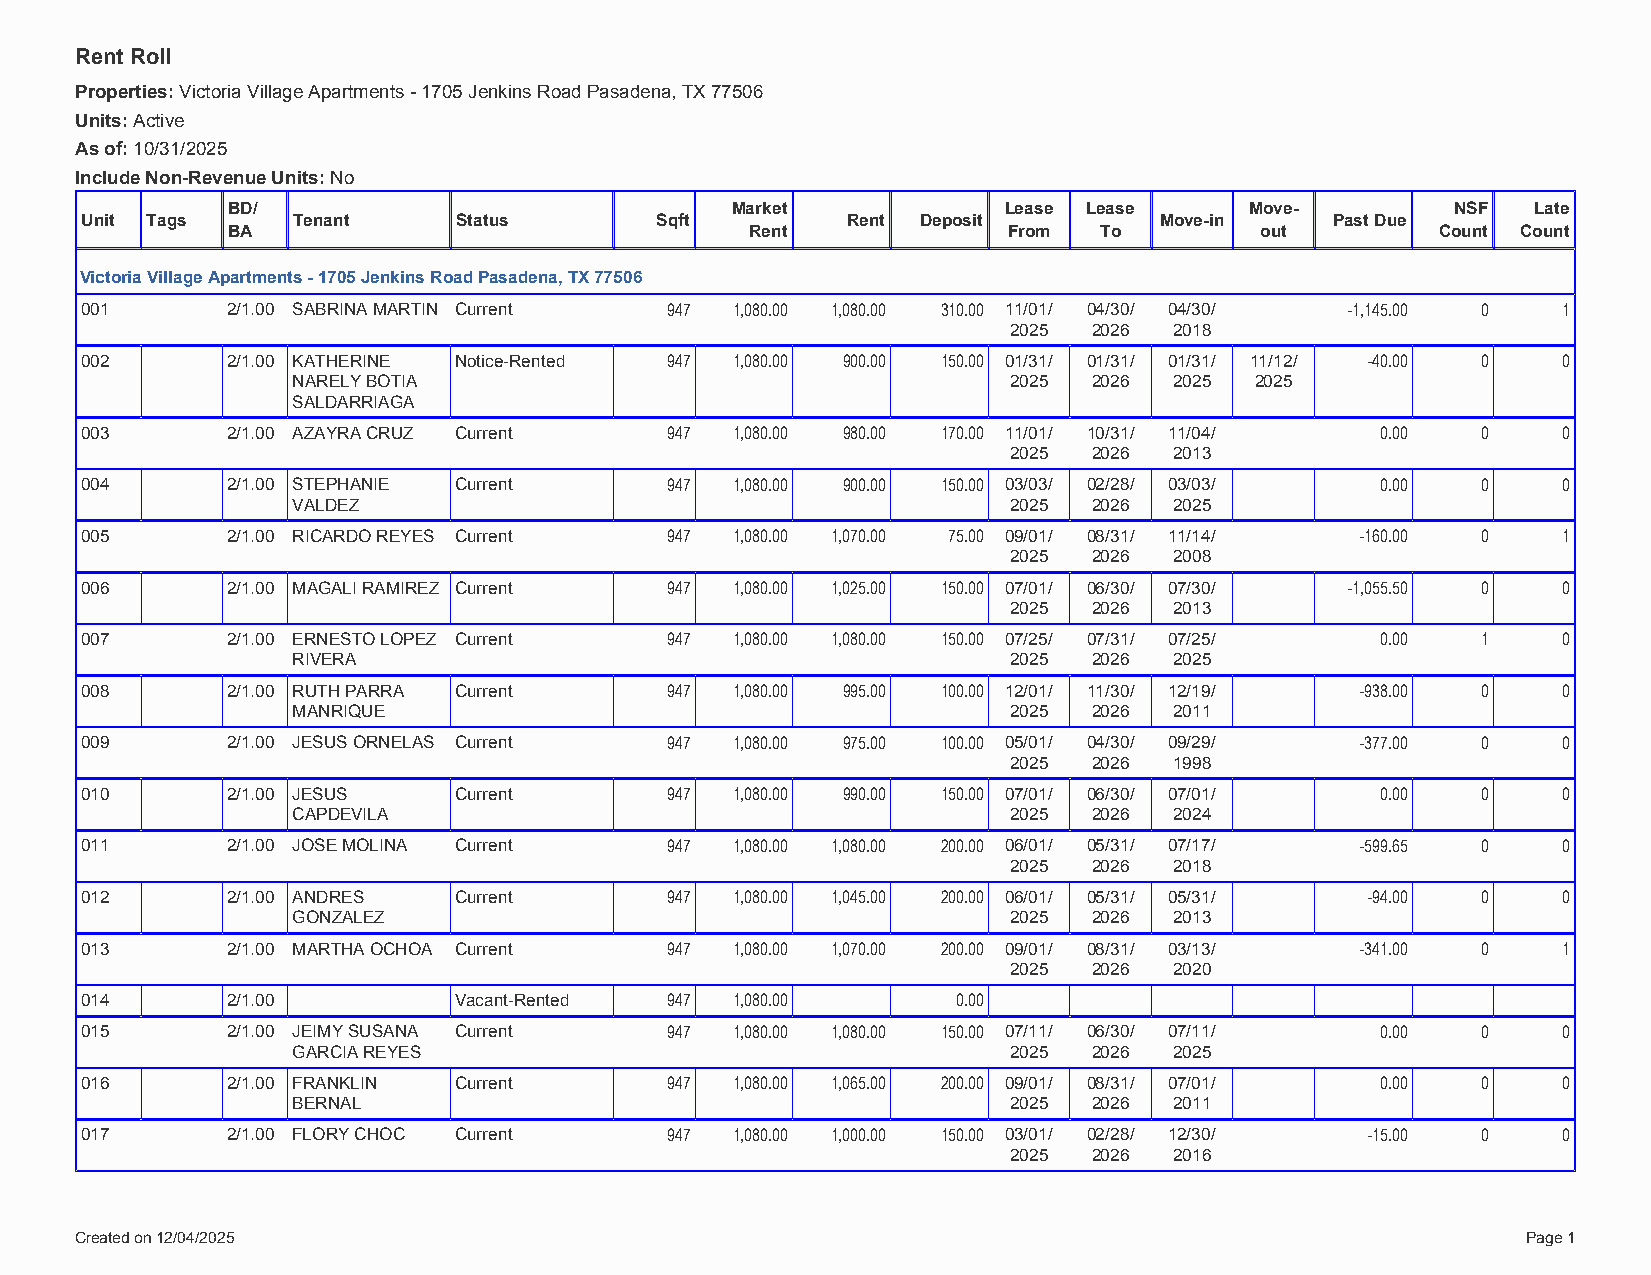

In [52]:
import matplotlib.pyplot as plt

page = pdf.pages[0]

im = page.to_image(resolution=150)


# Draw rectangles (header cell borders)
# im.draw_rects(page.rects, stroke="blue", stroke_width=1)

# Draw rectangles (header cell borders)
im.draw_rects(page.edges, stroke="blue", stroke_width=1)


im.show()

display(im)


In [36]:
print(len(page.lines))
print(len(page.rects))
print(len(page.edges))
print(len(page.bbox))
print(len(page.textboxverticals))
print(len(page.textboxhorizontals))
print(len(page.textlineverticals))
print(len(page.textlinehorizontals))
# print(len(page.textlines))
# print(len(page.text))




0
128
676
4
0
0
0
0


In [16]:
lines = page.lines

horizontal_lines = [
    l for l in lines
    if abs(l["y0"] - l["y1"]) < 1
]

print("Total horizontal lines:", len(horizontal_lines))
horizontal_lines[:5]


Total horizontal lines: 0


[]

In [17]:
rects = page.rects

# Focus on top part of page (headers)
header_rects = [
    r for r in rects
    if r["top"] < 150 and r["height"] > 15
]

print("Header rectangles found:", len(header_rects))

# Sort left → right
header_rects = sorted(header_rects, key=lambda r: r["x0"])

for i, r in enumerate(header_rects):
    print(i, round(r["x0"],1), round(r["x1"],1))


Header rectangles found: 0


In [18]:
def get_header_x_ranges(page):
    rects = [
        r for r in page.rects
        if r["top"] < 150 and r["height"] > 15
    ]
    rects = sorted(rects, key=lambda r: r["x0"])
    return [(round(r["x0"],1), round(r["x1"],1)) for r in rects]

first_page_cols = get_header_x_ranges(pdf.pages[0])

for i in [5, 10, 20, 30]:
    cols = get_header_x_ranges(pdf.pages[i])
    print(f"\nPage {i+1}")
    print(cols == first_page_cols)



Page 6
False

Page 11
False

Page 21
False

Page 31
False


In [19]:
def get_rows(page):
    h_lines = [
        l for l in page.lines
        if abs(l["y0"] - l["y1"]) < 1
    ]
    h_lines = sorted(h_lines, key=lambda l: l["y0"])

    rows = []
    for i in range(len(h_lines) - 1):
        rows.append((h_lines[i]["y0"], h_lines[i+1]["y0"]))
    return rows

rows = get_rows(page)
print("Detected rows:", len(rows))
rows[:3]


Detected rows: 0


[]

In [20]:
# Pick ONE row and ONE column manually
row_top, row_bottom = rows[2]        # 3rd row
col_left, col_right = first_page_cols[2]  # Tenant column (example)

cell = page.crop(
    (col_left, row_top, col_right, row_bottom)
).extract_text()

print(cell)


IndexError: list index out of range

In [23]:
preview = []

for row_top, row_bottom in rows[:5]:
    row_data = []
    for x0, x1 in first_page_cols:
        txt = page.crop((x0, row_top, x1, row_bottom)).extract_text()
        row_data.append(txt if txt else "")
    preview.append(row_data)

for r in preview:
    print(r)




---



In [37]:
import pdfplumber
from pprint import pprint

pdf = pdfplumber.open("/content/VV_Oct Rent Roll.pdf")
page = pdf.pages[0]

words = page.extract_words(
    x_tolerance=1,
    y_tolerance=3,
    keep_blank_chars=False
)

print("Total words:", len(words))
pprint(words[:10])


Total words: 363
[{'bottom': 32.85559999999998,
  'direction': 'ltr',
  'doctop': 22.35559999999998,
  'height': 10.5,
  'text': 'Rent',
  'top': 22.35559999999998,
  'upright': True,
  'width': 23.320499999999996,
  'x0': 36.0,
  'x1': 59.320499999999996},
 {'bottom': 32.85559999999998,
  'direction': 'ltr',
  'doctop': 22.35559999999998,
  'height': 10.5,
  'text': 'Roll',
  'top': 22.35559999999998,
  'upright': True,
  'width': 19.80300000000001,
  'x0': 62.229,
  'x1': 82.03200000000001},
 {'bottom': 48.84720000000004,
  'direction': 'ltr',
  'doctop': 39.84720000000004,
  'height': 9.0,
  'text': 'Properties:',
  'top': 39.84720000000004,
  'upright': True,
  'width': 47.47500000000001,
  'x0': 36.0,
  'x1': 83.47500000000001},
 {'bottom': 48.84720000000004,
  'direction': 'ltr',
  'doctop': 39.84720000000004,
  'height': 9.0,
  'text': 'Victoria',
  'top': 39.84720000000004,
  'upright': True,
  'width': 29.988,
  'x0': 86.0142,
  'x1': 116.0022},
 {'bottom': 48.84720000000004,


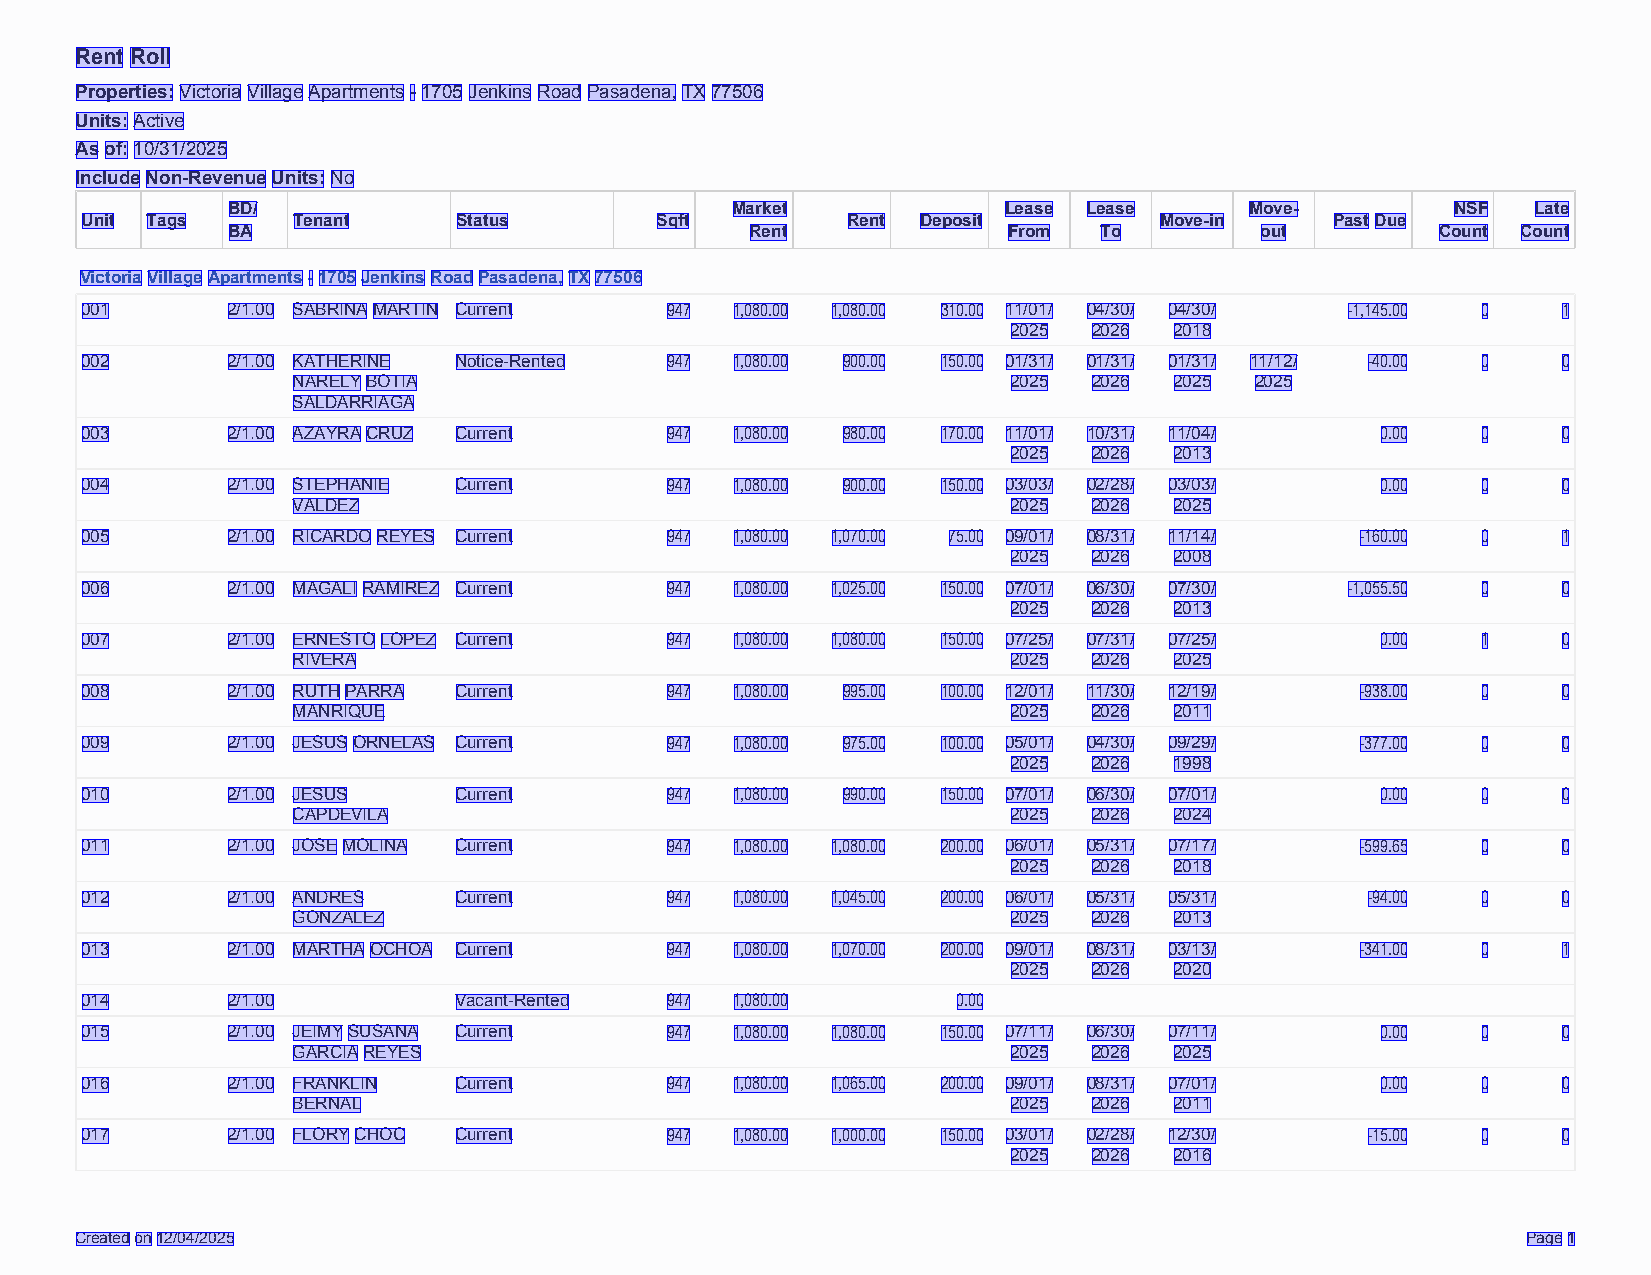

In [39]:
im = page.to_image(resolution=150)

for w in words:
    im.draw_rect(
        (w["x0"], w["top"], w["x1"], w["bottom"]),
        stroke="blue",
        stroke_width=1
    )

im.show()
display(im)


In [41]:
import numpy as np

x_centers = sorted(
    [(w["x0"] + w["x1"]) / 2 for w in words]
)

# Cluster x positions
clusters = []
threshold = 15  # pixels

for x in x_centers:
    if not clusters or abs(clusters[-1] - x) > threshold:
        clusters.append(x)

print("Detected columns:", len(clusters))
clusters


Detected columns: 27


[41.751,
 59.737500000000004,
 76.2421,
 93.92250000000001,
 115.31790000000001,
 131.9952,
 149.197965975,
 164.26170000000002,
 179.64369999999997,
 195.89207499999998,
 211.9692,
 231.41025,
 249.7572159749999,
 268.34055959999995,
 296.82894479999976,
 322.80555000000004,
 353.57955959999987,
 411.85159999999996,
 456.4157,
 493.71485,
 532.80445,
 571.891875,
 610.98385,
 648.224375,
 663.7178,
 701.987425,
 740.9817]

In [42]:
columns = []

for c in clusters:
    columns.append((c - 25, c + 25))

columns


[(16.750999999999998, 66.751),
 (34.737500000000004, 84.73750000000001),
 (51.24209999999999, 101.2421),
 (68.92250000000001, 118.92250000000001),
 (90.31790000000001, 140.3179),
 (106.99520000000001, 156.9952),
 (124.19796597499999, 174.197965975),
 (139.26170000000002, 189.26170000000002),
 (154.64369999999997, 204.64369999999997),
 (170.89207499999998, 220.89207499999998),
 (186.9692, 236.9692),
 (206.41025, 256.41025),
 (224.7572159749999, 274.7572159749999),
 (243.34055959999995, 293.34055959999995),
 (271.82894479999976, 321.82894479999976),
 (297.80555000000004, 347.80555000000004),
 (328.57955959999987, 378.57955959999987),
 (386.85159999999996, 436.85159999999996),
 (431.4157, 481.4157),
 (468.71485, 518.7148500000001),
 (507.80445, 557.80445),
 (546.891875, 596.891875),
 (585.98385, 635.98385),
 (623.224375, 673.224375),
 (638.7178, 688.7178),
 (676.987425, 726.987425),
 (715.9817, 765.9817)]

In [43]:
y_centers = sorted(
    [(w["top"] + w["bottom"]) / 2 for w in words]
)

row_centers = []
row_gap = 12

for y in y_centers:
    if not row_centers or abs(row_centers[-1] - y) > row_gap:
        row_centers.append(y)

print("Detected rows:", len(row_centers))
row_centers[:5]


Detected rows: 26


[27.60559999999998,
 44.34720000000004,
 58.14610000000005,
 71.94489999999996,
 85.74369999999999]

In [44]:
def find_column(x, columns):
    for i, (x0, x1) in enumerate(columns):
        if x0 <= x <= x1:
            return i
    return None

table = {}

for w in words:
    row = min(row_centers, key=lambda y: abs(y - (w["top"] + w["bottom"]) / 2))
    col = find_column((w["x0"] + w["x1"]) / 2, columns)

    if col is None:
        continue

    table.setdefault(row, {}).setdefault(col, []).append(w["text"])


In [45]:
for r in sorted(table.keys())[:5]:
    row = []
    for c in range(len(columns)):
        cell = " ".join(table[r].get(c, []))
        row.append(cell)
    print(row)


['Rent', 'Roll', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['Properties:', '', 'Victoria', '', 'Village', '', 'Apartments', '', '-', '1705', '', 'Jenkins', 'Road', '', 'Pasadena,', 'TX', '77506', '', '', '', '', '', '', '', '', '', '']
['Units:', 'Active', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['As of:', '', '10/31/2025', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['Include', '', 'Non-Revenue', '', '', 'Units:', 'No', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']




---
aistudio


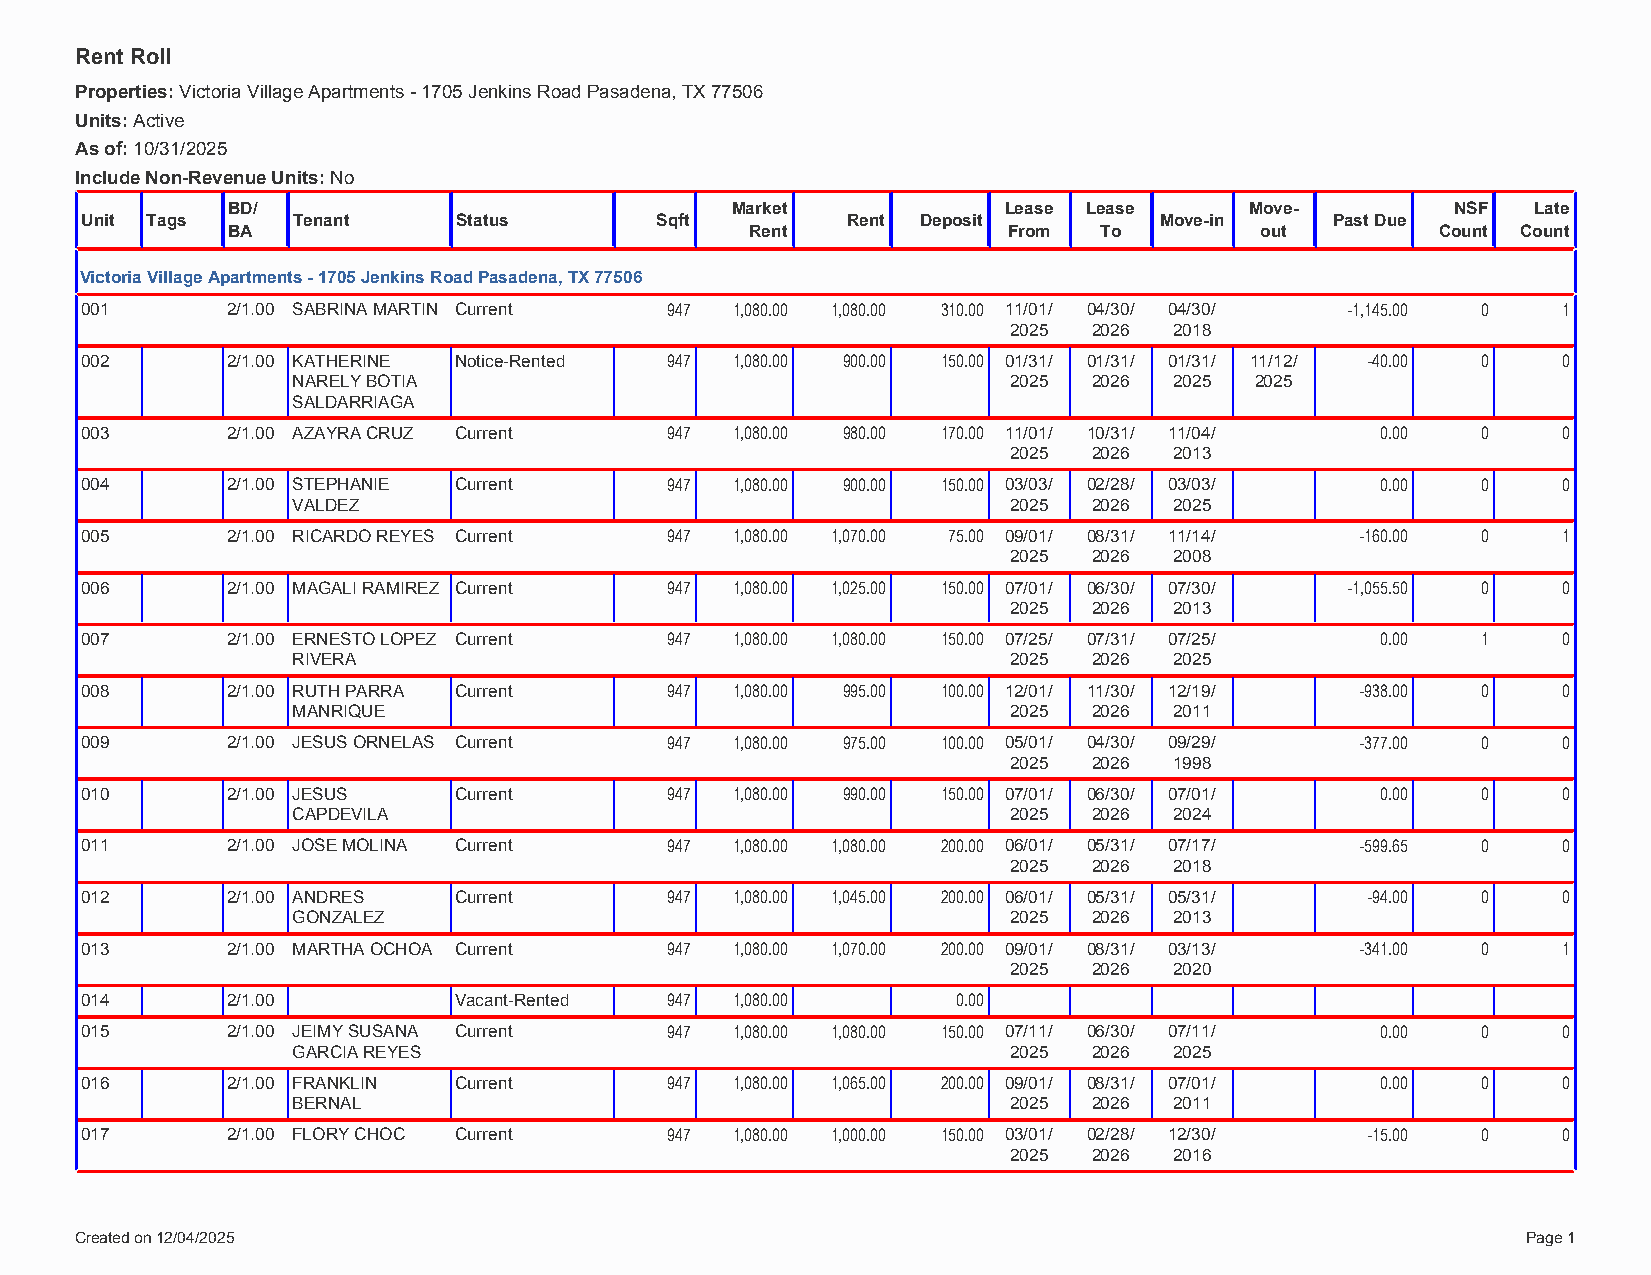

In [54]:
import pdfplumber
import matplotlib.pyplot as plt

# Load the pdf
pdf = pdfplumber.open("/content/VV_Oct Rent Roll.pdf")
page = pdf.pages[0]

# Create an image for visualization
im = page.to_image(resolution=150)

# Filter edges by orientation
# We want to see if we can rely on horizontal lines for row splitting
h_lines = [e for e in page.edges if e['orientation'] == 'h']
v_lines = [e for e in page.edges if e['orientation'] == 'v']

# Draw Horizontal lines in RED
im.draw_rects(h_lines, stroke="red", stroke_width=2)

# Draw Vertical lines in BLUE
im.draw_rects(v_lines, stroke="blue", stroke_width=2)

im.show()
display(im)

In [55]:
# specific analysis of vertical lines
v_lines = [e for e in page.edges if e['orientation'] == 'v']

print(f"Total Vertical Lines Found: {len(v_lines)}")

# Let's print the X-coordinates of the first 20 vertical lines to see if they group together
# We sort them by top (y0) position first, then x0
sorted_v = sorted(v_lines, key=lambda x: (x['top'], x['x0']))

print("\n--- Sample Vertical Lines (Top 20) ---")
print(f"{'X-Pos':<10} {'Top':<10} {'Bottom':<10} {'Height':<10}")
for line in sorted_v[:20]:
    print(f"{line['x0']:<10.2f} {line['top']:<10.2f} {line['bottom']:<10.2f} {line['height']:<10.2f}")

Total Vertical Lines Found: 298

--- Sample Vertical Lines (Top 20) ---
X-Pos      Top        Bottom     Height    
36.00      91.20      119.70     28.50     
68.02      91.20      119.70     28.50     
107.11     91.20      119.70     28.50     
138.38     91.20      119.70     28.50     
216.56     91.20      119.70     28.50     
294.74     91.20      119.70     28.50     
333.83     91.20      119.70     28.50     
380.74     91.20      119.70     28.50     
427.65     91.20      119.70     28.50     
474.55     91.20      119.70     28.50     
513.64     91.20      119.70     28.50     
552.73     91.20      119.70     28.50     
591.82     91.20      119.70     28.50     
630.91     91.20      119.70     28.50     
677.82     91.20      119.70     28.50     
716.91     91.20      119.70     28.50     
756.00     91.20      119.70     28.50     
36.75      91.95      118.95     27.00     
67.27      91.95      118.95     27.00     
106.36     91.95      118.95     27.00     


In [56]:
h_lines = [e for e in page.edges if e['orientation'] == 'h']

print(f"Total Horizontal Lines Found: {len(h_lines)}")

# Sort by vertical position (top)
sorted_h = sorted(h_lines, key=lambda x: x['top'])

print("\n--- Sample Horizontal Lines (Top 20) ---")
print(f"{'Y-Pos':<10} {'Left':<10} {'Right':<10} {'Width':<10}")
for line in sorted_h[:20]:
    print(f"{line['top']:<10.2f} {line['x0']:<10.2f} {line['x1']:<10.2f} {line['width']:<10.2f}")

Total Horizontal Lines Found: 296

--- Sample Horizontal Lines (Top 20) ---
Y-Pos      Left       Right      Width     
91.20      36.00      756.00     720.00    
91.95      36.75      755.25     718.50    
118.95     36.00      756.00     720.00    
119.70     36.75      755.25     718.50    
140.70     36.00      756.00     720.00    
141.45     36.75      755.25     718.50    
165.45     36.00      756.00     720.00    
165.82     36.38      67.65      31.27     
165.82     67.65      106.74     39.09     
165.82     106.74     138.01     31.27     
165.82     138.01     216.19     78.18     
165.82     216.19     294.37     78.18     
165.82     294.37     333.46     39.09     
165.82     333.46     380.36     46.91     
165.82     380.36     427.27     46.91     
165.82     427.27     474.18     46.91     
165.82     474.18     513.27     39.09     
165.82     513.27     552.36     39.09     
165.82     552.36     591.45     39.09     
165.82     591.45     630.54     39.09     


In [58]:
import pdfplumber
import pandas as pd

def extract_rent_roll(pdf_path):
    pdf = pdfplumber.open(pdf_path)
    page = pdf.pages[0]  # Start with page 0, loop later if needed

    # ==========================================
    # STEP 1: Define Columns (Using Header Vertical Lines)
    # ==========================================
    # We filter for vertical lines that are specifically in the header area
    # Based on your data: Top is ~91.20, Bottom is ~119.70
    v_lines = [e for e in page.edges if e['orientation'] == 'v']

    header_v_lines = [
        line for line in v_lines
        if 90 <= line['top'] <= 95  # Looking for lines starting at ~91.20
    ]

    # Get all X-coordinates from these lines
    x_coords = sorted([line['x0'] for line in header_v_lines])

    # Filter out duplicate lines (double borders).
    # Example: 36.00 and 36.75 are basically the same border.
    unique_x = []
    if x_coords:
        unique_x.append(x_coords[0])
        for x in x_coords[1:]:
            # Only add if it's more than 5 pixels away from the last one
            if x - unique_x[-1] > 5:
                unique_x.append(x)

    print(f"Detected {len(unique_x)-1} Columns based on Header.")

    # ==========================================
    # STEP 2: Define Rows (Using Horizontal Lines)
    # ==========================================
    # Filter for lines that act as row separators (Long width)
    h_lines = [e for e in page.edges if e['orientation'] == 'h']

    # Your data showed page width is ~720. Let's filter for lines > 600 width.
    row_lines = [line for line in h_lines if line['width'] > 600]

    # Get Y-coordinates
    y_coords = sorted([line['top'] for line in row_lines])

    # Filter duplicates (top and bottom of a thick border)
    unique_y = []
    if y_coords:
        unique_y.append(y_coords[0])
        for y in y_coords[1:]:
            if y - unique_y[-1] > 5:
                unique_y.append(y)

    print(f"Detected {len(unique_y)-1} Rows.")

    # ==========================================
    # STEP 3: Extract Data Grid
    # ==========================================
    table_data = []

    # Loop through each Row interval
    for i in range(len(unique_y) - 1):
        top = unique_y[i]
        bottom = unique_y[i+1]

        row_data = []

        # Loop through each Column interval
        for j in range(len(unique_x) - 1):
            left = unique_x[j]
            right = unique_x[j+1]

            # Define the specific box for this cell
            # Box format: (x0, top, x1, bottom)
            cell_box = (left, top, right, bottom)

            # Crop the page to this tiny box and extract text
            cell_crop = page.crop(cell_box)
            text = cell_crop.extract_text()

            # CLEANING:
            # 1. If text is None, make it empty string
            # 2. Replace newlines with space (Fixes the "05/01/ \n 2025" issue)
            if text:
                clean_text = text.replace('\n', ' ').strip()
            else:
                clean_text = ""

            row_data.append(clean_text)

        table_data.append(row_data)

    return table_data

# ==========================================
# EXECUTION
# ==========================================
path = "/content/VV_Oct Rent Roll.pdf"
data = extract_rent_roll(path)

# Create DataFrame
# The first row in 'data' is usually the Header row, we can set it as columns
df = pd.DataFrame(data[1:], columns=data[0])

# Show result
print("\n--- Extracted Data Sample ---")
print(df.head(10).to_markdown(index=False))

# Option to save
df.to_csv("rent_roll_extracted.csv", index=False)

Detected 16 Columns based on Header.
Detected 19 Rows.

--- Extracted Data Sample ---
| Unit     | Tags         | BD/ BA   | Tenant                             | Status              |   Sqft | Market Rent   | Rent     | Deposit   | Lease From   | Lease To    | Move-in     | Move- out   | Past Due   | NSF Count   | Late Count   |
|:---------|:-------------|:---------|:-----------------------------------|:--------------------|-------:|:--------------|:---------|:----------|:-------------|:------------|:------------|:------------|:-----------|:------------|:-------------|
| Victoria | a Village Ap | partmen  | nts - 1705 Jenkins Ro              | oad Pasadena, TX 77 |   7506 |               |          |           |              |             |             |             |            |             |              |
| 001      |              | 2/1.00   | SABRINA MARTIN                     | Current             |    947 | 1,080.00      | 1,080.00 | 310.00    | 11/01/ 2025  | 04/30/ 2026 | 04/3

In [59]:
import pdfplumber
import pandas as pd

def extract_rent_roll_all_pages(pdf_path):
    pdf = pdfplumber.open(pdf_path)

    # ==========================================
    # PHASE 1: Define Master Columns (From Page 0)
    # ==========================================
    # We use Page 0 as the "Template" to define where columns start/end.
    # This ensures consistency across all pages.
    p0 = pdf.pages[0]
    v_lines = [e for e in p0.edges if e['orientation'] == 'v']

    # Filter for vertical lines in the header area (Top ~91-120 based on your analysis)
    header_v_lines = [
        line for line in v_lines
        if 90 <= line['top'] <= 95
    ]

    # Get X-coordinates and filter duplicates
    x_coords = sorted([line['x0'] for line in header_v_lines])
    unique_x = []
    if x_coords:
        unique_x.append(x_coords[0])
        for x in x_coords[1:]:
            if x - unique_x[-1] > 5: # Filter close duplicates
                unique_x.append(x)

    print(f"Template Defined: Found {len(unique_x)-1} Columns from Page 0.")

    all_pages_data = []

    # ==========================================
    # PHASE 2: Iterate All Pages
    # ==========================================
    for i, page in enumerate(pdf.pages):
        print(f"Processing Page {i+1}...")

        # 1. Detect Rows for THIS specific page
        h_lines = [e for e in page.edges if e['orientation'] == 'h']

        # Filter for long row separators (Width > 600)
        row_lines = [line for line in h_lines if line['width'] > 600]

        # Get Y-coordinates and filter duplicates
        y_coords = sorted([line['top'] for line in row_lines])
        unique_y = []
        if y_coords:
            unique_y.append(y_coords[0])
            for y in y_coords[1:]:
                if y - unique_y[-1] > 5:
                    unique_y.append(y)

        # If no rows found (e.g., blank page), skip
        if len(unique_y) < 2:
            continue

        # 2. Extract Data from Grid
        # Loop through row intervals
        for r in range(len(unique_y) - 1):
            top = unique_y[r]
            bottom = unique_y[r+1]

            row_data = []

            # Loop through the Master Column intervals
            for c in range(len(unique_x) - 1):
                left = unique_x[c]
                right = unique_x[c+1]

                # Define box
                cell_box = (left, top, right, bottom)

                # Extract
                try:
                    cell_crop = page.crop(cell_box)
                    text = cell_crop.extract_text()

                    if text:
                        # Fix multi-line issues
                        clean_text = text.replace('\n', ' ').strip()
                    else:
                        clean_text = ""
                except Exception:
                    # Handle edge cases where crop might be out of bounds slightly
                    clean_text = ""

                row_data.append(clean_text)

            all_pages_data.append(row_data)

    return all_pages_data

# ==========================================
# EXECUTION & CLEANING
# ==========================================
path = "/content/VV_Oct Rent Roll.pdf"
raw_data = extract_rent_roll_all_pages(path)

if raw_data:
    # 1. Create DataFrame using the first row as header
    headers = raw_data[0]
    df = pd.DataFrame(raw_data[1:], columns=headers)

    # 2. Remove Repeated Headers
    # Since every page has the header row, we filter out rows where "Unit" (Col 0) appears again
    # We assume the first column is named "Unit" based on your screenshot
    if "Unit" in df.columns:
        df = df[df["Unit"] != "Unit"]

    # 3. Final Check
    print(f"\nExtraction Complete. Total Rows: {len(df)}")
    print(df.head(5).to_markdown(index=False))

    # 4. Save
    df.to_csv("/content/Full_Rent_Roll.csv", index=False)
    print("\nSaved to /content/Full_Rent_Roll.csv")
else:
    print("No data extracted.")

Template Defined: Found 16 Columns from Page 0.
Processing Page 1...
Processing Page 2...
Processing Page 3...
Processing Page 4...
Processing Page 5...
Processing Page 6...
Processing Page 7...
Processing Page 8...
Processing Page 9...
Processing Page 10...
Processing Page 11...
Processing Page 12...
Processing Page 13...
Processing Page 14...
Processing Page 15...
Processing Page 16...
Processing Page 17...
Processing Page 18...
Processing Page 19...
Processing Page 20...
Processing Page 21...
Processing Page 22...
Processing Page 23...
Processing Page 24...
Processing Page 25...
Processing Page 26...
Processing Page 27...
Processing Page 28...
Processing Page 29...
Processing Page 30...
Processing Page 31...

Extraction Complete. Total Rows: 626
| Unit     | Tags         | BD/ BA   | Tenant                             | Status              |   Sqft | Market Rent   | Rent     | Deposit   | Lease From   | Lease To    | Move-in     | Move- out   | Past Due   | NSF Count   | Late Count 

## Final (little fix: commercial multifamily)

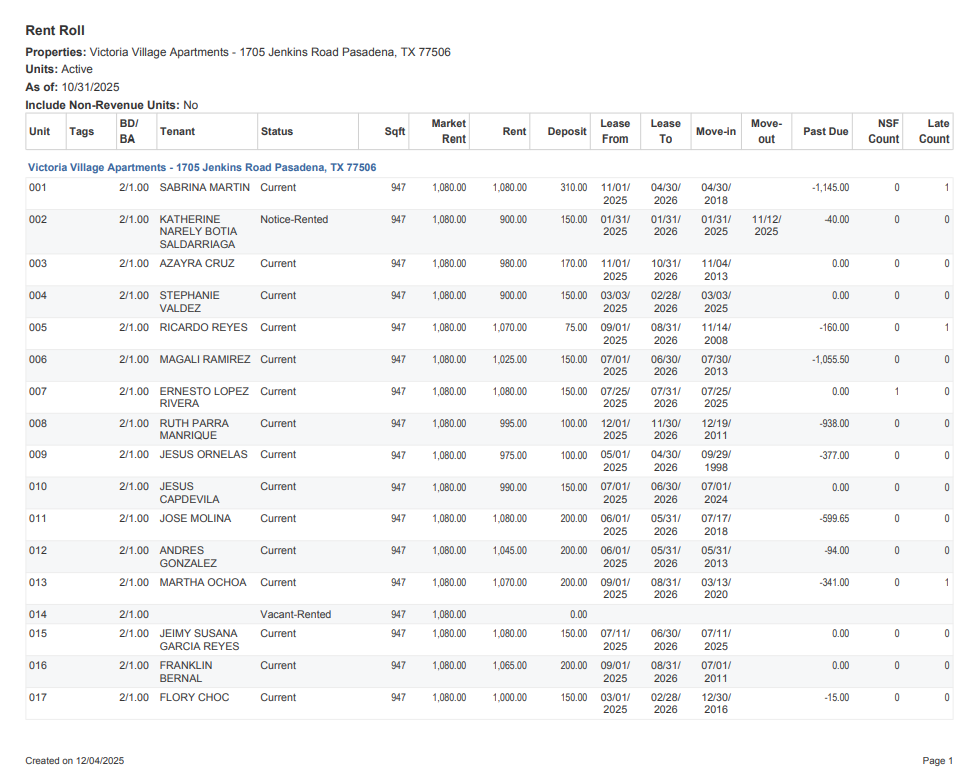

In [60]:
import pdfplumber
import pandas as pd

def extract_rent_roll_advanced(pdf_path):
    pdf = pdfplumber.open(pdf_path)

    # ==========================================
    # PHASE 1: Define Master Columns (From Page 0)
    # ==========================================
    p0 = pdf.pages[0]
    v_lines = [e for e in p0.edges if e['orientation'] == 'v']
    header_v_lines = [line for line in v_lines if 90 <= line['top'] <= 95]

    x_coords = sorted([line['x0'] for line in header_v_lines])
    unique_x = []
    if x_coords:
        unique_x.append(x_coords[0])
        for x in x_coords[1:]:
            if x - unique_x[-1] > 5:
                unique_x.append(x)

    all_pages_data = []

    # ==========================================
    # PHASE 2: Iterate All Pages & Extract Raw Data
    # ==========================================
    for i, page in enumerate(pdf.pages):
        # Detect Rows for THIS specific page
        h_lines = [e for e in page.edges if e['orientation'] == 'h']
        row_lines = [line for line in h_lines if line['width'] > 600]
        y_coords = sorted([line['top'] for line in row_lines])

        unique_y = []
        if y_coords:
            unique_y.append(y_coords[0])
            for y in y_coords[1:]:
                if y - unique_y[-1] > 5:
                    unique_y.append(y)

        if len(unique_y) < 2: continue

        # Extract Grid
        for r in range(len(unique_y) - 1):
            row_data = []
            for c in range(len(unique_x) - 1):
                cell_box = (unique_x[c], unique_y[r], unique_x[c+1], unique_y[r+1])
                try:
                    text = page.crop(cell_box).extract_text()
                    clean_text = text.replace('\n', ' ').strip() if text else ""
                except:
                    clean_text = ""
                row_data.append(clean_text)

            all_pages_data.append(row_data)

    return all_pages_data

def clean_and_merge_rows(raw_data):
    """
    Fixes the issue where data spills over to the next page/row.
    Logic: If a row has an EMPTY 'Unit' (Col 0) but has data elsewhere,
    it is merged into the previous row.
    """
    if not raw_data: return []

    # 1. Separate Header from Data
    header = raw_data[0]
    data_rows = raw_data[1:]

    # 2. Filter out repeated headers (from multiple pages)
    # We assume Column 0 is "Unit". We remove rows where Col 0 says "Unit"
    cleaned_rows = [row for row in data_rows if row[0] != "Unit"]

    merged_data = []
    if not cleaned_rows: return [header]

    # Start with the first data row
    current_primary_row = cleaned_rows[0]

    for i in range(1, len(cleaned_rows)):
        next_row = cleaned_rows[i]

        # CHECK: Is this a "Spillover" row?
        # Condition: Unit (Col 0) is Empty AND it has some content in other columns
        has_no_unit = (next_row[0] == "")
        has_content = any(cell != "" for cell in next_row)

        if has_no_unit and has_content:
            # === MERGE LOGIC ===
            # Combine next_row into current_primary_row
            new_merged_row = []
            for k in range(len(current_primary_row)):
                val_main = current_primary_row[k]
                val_spill = next_row[k]

                # Join with space if both exist, otherwise take whichever exists
                if val_main and val_spill:
                    new_merged_row.append(f"{val_main} {val_spill}")
                else:
                    new_merged_row.append(val_main + val_spill)

            # Update the primary row with the merged result
            current_primary_row = new_merged_row
        else:
            # It's a normal new row. Save the finished primary row and start a new one.
            merged_data.append(current_primary_row)
            current_primary_row = next_row

    # Append the final processing row
    merged_data.append(current_primary_row)

    # Return Header + Merged Data
    return [header] + merged_data

# ==========================================
# EXECUTION
# ==========================================
path = "/content/VV_Oct Rent Roll.pdf"

# 1. Get Raw Data (includes broken rows)
raw_data = extract_rent_roll_advanced(path)

# 2. Clean and Merge (Fixes Franklin Aquino & Dates)
final_data = clean_and_merge_rows(raw_data)

# 3. Create DataFrame
if final_data:
    headers = final_data[0]
    df = pd.DataFrame(final_data[1:], columns=headers)

    print(f"Extraction Complete. Final Rows: {len(df)}")

    # Save
    df.to_csv("/content/Perfect_Rent_Roll.csv", index=False)
    print("Saved to /content/Perfect_Rent_Roll.csv")

    # Verify the "Franklin" case (Optional: Print rows around index 400)
    # This helps you check if it worked
    print("\n--- Check Data End ---")
    print(df.tail(10).to_markdown(index=False))

Extraction Complete. Final Rows: 616
Saved to /content/Perfect_Rent_Roll.csv

--- Check Data End ---
| Unit            | Tags   | BD/ BA   | Tenant                       | Status         | Sqft    | Market Rent   | Rent       | Deposit   | Lease From   | Lease To    | Move-in     | Move- out   | Past Due    | NSF Count   | Late Count   |
|:----------------|:-------|:---------|:-----------------------------|:---------------|:--------|:--------------|:-----------|:----------|:-------------|:------------|:------------|:------------|:------------|:------------|:-------------|
| 606             |        | 1/1.00   | KEVIN FABRICIO SORTO FUENTES | Current        | 746     | 895.00        | 895.00     | 150.00    | 07/06/ 2025  | 06/30/ 2026 | 07/06/ 2025 |             | 0.00        | 0           | 0            |
| 607             |        | 1/1.00   | Annette Ochoa                | Current        | 746     | 895.00        | 795.00     | 150.00    | 12/01/ 2025  | 11/30/ 2026 | 11/27/ 2024 | 